In [ ]:
########################
# Setup
########################
from google.colab import drive
drive.mount('/content/drive')

import sys
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import io
import openpyxl  # Import openpyxl for Excel export

import plotly.express as px
import plotly.graph_objects as go
from scipy import stats
from scipy.stats import chi2_contingency, fisher_exact, mannwhitneyu

from google.colab import data_table
data_table.enable_dataframe_formatter()

df=pd.read_csv('drive/MyDrive/iGAS_PICU_final_merged_coded_data.csv')  #manually edited so only has one micro source for each patient, prioritised anatomical source if true
df.columns = df.columns.str.strip() #Strip out extra spaces

# Versions for methods
print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Seaborn version: {sns.__version__}")
print(f"Pandas version: {pd.__version__}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Python version: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
NumPy version: 1.26.4
Seaborn version: 0.13.2
Pandas version: 2.2.2


In [ ]:
########################
# Section 1 - Summary of cases
########################

In [ ]:
### 1.1 Table 1 - summary table of statistics split by alive status ###

# Helper function - format to 2 sf
def format_to_2sf(x):
    return f"{x:.4g}"

# Make Summary Table
def create_summary_table(df):

    # Helper function to calculate percentages
    def calculate_percentages(group):
        return group / group.sum() * 100

    # Create the summary table
    summary_table = pd.DataFrame()

    for alive_status in [0, 1]:
        alive_group = df[df['alive'] == alive_status]

        # Male/Female counts and percentages
        male_female_counts = alive_group['male'].value_counts()
        male_female_percentages = calculate_percentages(male_female_counts)

        # Age at admission (months)
        mean_age = alive_group['age_ad_months'].mean()
        median_age = alive_group['age_ad_months'].median()
        age_data = alive_group['age_ad_months'].dropna()  # Remove missing values
        iqr_lower = np.percentile(age_data, 25)
        iqr_higher = np.percentile(age_data, 75)
        age_range = age_data.max() - age_data.min()

        # Ethnicity (white vs. non-white)
        ethnicity_counts = alive_group['ethnicity'].value_counts()
        white_count = ethnicity_counts.get(1, 0)
        non_white_count = ethnicity_counts.sum() - white_count

        ###  SIMD counts
        # 1. Total non-blank SIMD counts:
        total_non_blank_simd_count = alive_group['simd'].notna().sum()

        # 2. SIMD counts 2 or below:
        simd_2_or_below = (len(alive_group[(alive_group['simd'] <= 2) & (alive_group['simd'].notna())])) / total_non_blank_simd_count * 100

        # 3. SIMD counts 2 and above:
        simd_above_2 = (len(alive_group[(alive_group['simd'] > 2) & (alive_group['simd'].notna())])) / total_non_blank_simd_count * 100

        # Cormorbidity
        comorbidity_counts = alive_group['comorbid'].value_counts()

        # Append to the summary table
        temp_df = pd.DataFrame({
            'Alive': [alive_status],
            'Male (Count)': [male_female_counts.get(1, 0)],
            'Male (%)': [male_female_percentages.get(1, 0)],
            'Female (Count)': [male_female_counts.get(0, 0)],
            'Female (%)': [male_female_percentages.get(0, 0)],
            'Mean Age (Months)': [mean_age],
            'Median Age (Months)': [median_age],
            'Age IQR (Lower - Months)': [iqr_lower],
            'Age IQR (Higher - Months)': [iqr_higher],
            'Min age (Months)': [age_data.min()],
            'Max age (Months)': [age_data.max()],
            'White (Count)': [white_count],
            'White (%)': [white_count / len(alive_group) * 100 if len(alive_group) > 0 else 0],
            'Non-White (Count)': [non_white_count],
            'Non-white (%)': [non_white_count / len(alive_group) * 100 if len(alive_group) > 0 else 0],
            'SIMD: % quintiles 1 and 2': [simd_2_or_below],
            'SIMD: % above 2nd quintile': [simd_above_2],
            'Cormorbidity (Count)': [comorbidity_counts.get(1, 0)],
            'Cormorbidity (%)': [comorbidity_counts.get(1, 0) / len(alive_group) * 100 if len(alive_group) > 0 else 0]
        })
        summary_table = pd.concat([summary_table, temp_df], ignore_index=True)

    return summary_table

summary_table = create_summary_table(df)
summary_table = summary_table.T
display(summary_table.style.format(format_to_2sf))

summary_table.to_excel("ScotlandiGAS-Table1.xlsx")


In [ ]:
########################
# Section 2 - 10 year national trend
########################

In [ ]:
### 2.2 - Main figure, and calculation of phenotype differences

# For deaths need to explictly put in zeros and reorder so the line goes between years
deaths_by_year = df[df['alive'] == 0].groupby('season_start')['alive'].count().reset_index()
deaths_by_year = deaths_by_year.rename(columns={'alive': 'deaths'})

for year in list(range(2013, 2022)):
    if year not in deaths_by_year['season_start'].values:
        deaths_by_year = pd.concat([deaths_by_year, pd.DataFrame({'season_start': [year], 'deaths': [0]})], ignore_index=True)
deaths_by_year.sort_values(by=['season_start'], inplace=True)

df_phenotype = df.groupby(['clinical_phen', 'season_start']).size().reset_index().pivot(columns='clinical_phen', index='season_start', values=0)
df_phenotype.rename(columns={1: 'Respiratory', 2: 'Sepsis', 3: 'Skin, soft tissue and bone'}, inplace=True)

#Main figure
fig = px.bar(df_phenotype, color="clinical_phen")

#Add the deaths line
deaths_trace = go.Scatter(
    x=deaths_by_year['season_start'],
    y=deaths_by_year['deaths'],
    mode='lines+markers',
    name='Deaths (all locations)',
    line=dict(color='black')
)
fig.add_trace(deaths_trace)

fig.update_xaxes(tick0=1, dtick=1, tickangle=-30)
fig.update_layout(
    title="Scottish PICU admissions and deaths with iGAS",
    xaxis_title="Season year (start)",
    yaxis_title="Number of Patients",
    legend_title="Clinical Phenotype"
)

print("# FIGURE 1 - 10 year trend \n")
fig.show()

#### Statistics - were there really more in 2022 vs pre-Covid?

# Create a contingency table
contingency_table = pd.DataFrame({
    'Year': ['2022', 'Pre-2020'],
    'Respiratory': [df[(df['season_start'] == 2022) & (df['clinical_phen'] == 1)]['clinical_phen'].count(),
                     df[(df['season_start'] < 2020) & (df['clinical_phen'] == 1)]['clinical_phen'].count()],
    'Other': [df[(df['season_start'] == 2022) & (df['clinical_phen'] != 1)]['clinical_phen'].count(),
              df[(df['season_start'] < 2020) & (df['clinical_phen'] != 1)]['clinical_phen'].count()]
})

# Perform Chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table[['Respiratory', 'Other']])

print("# Were there proportionally more respiratory cases in 2022?\n")
print(f"Chi-squared statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print(f"Expected frequencies: {expected}")


# FIGURE 1 - 10 year trend 



# Were there proportionally more respiratory cases in 2022?

Chi-squared statistic: 1.7197787397787399
P-value: 0.18972152849844465
Degrees of freedom: 1
Expected frequencies: [[ 9.94736842 11.05263158]
 [26.05263158 28.94736842]]


In [ ]:
### 2.2 - population based risk estimates - ?add the admission death to admissions
## Population at risk
scottish_pop = pd.read_csv(io.StringIO('''
year,under 16s
2013,911490
2014,911795
2015,912046
2016,913627
2017,913074
2018,910710
2019,909453
2020,903205
2021,898594
2022,891892
'''), header=0)

fig = px.line(scottish_pop, x='year', y='under 16s')
fig.update_layout(
    title="Population under 16 years in Scotland",
    xaxis_title="Year (middle)",
    yaxis_title="Population <16 years",
)

fig.update_xaxes(tick0=2013, dtick=1, tickangle=-30)
yaxis_range=[700000,1000000]
fig.update_yaxes(range=yaxis_range)

fig.show()

### risk table
data = []

# Get the unique years from the 'season_start' column in df
years = df['season_start'].unique()
years = years[~np.isnan(years)]

# Iterate over the years
for year in years:
    # Get the admissions and deaths for the current year
    admissions = df[(df['season_start'] == year) & (df['alive'] == 1)]['alive'].count()
    deaths = df[(df['season_start'] == year) & (df['alive'] == 0)]['alive'].count()

    # Get population scottish_pop
    population = scottish_pop.loc[scottish_pop['year'] == year, 'under 16s'].iloc[0]

    # Calculate the admissions and deaths per 100,000
    admissions_per_100k = (admissions / population) * 100000
    deaths_per_100k = (deaths / population) * 100000

    # Append the data to the list
    data.append([year, admissions, deaths, population, admissions_per_100k, deaths_per_100k])

# Create the new dataframe from the list
epi_summary = pd.DataFrame(data, columns=['year', 'admissions', 'deaths', 'population', 'admissions_per_100k', 'deaths_per_100k'])
epi_summary = epi_summary.sort_values(by=['year'])

# Display
print("# TABLE 1: Population risk estimates \n")
display(epi_summary.style.format({'year': '{:.0f}', 'admissions_per_100k': '{:.2f}', 'deaths_per_100k': '{:.2f}'}))

# Calculate average values for 2013-2019
pre_2020_data = epi_summary[epi_summary['year'].isin(range(2013, 2020))]
avg_admissions = pre_2020_data['admissions'].mean()
avg_deaths = pre_2020_data['deaths'].mean()
avg_admissions_per_100k = pre_2020_data['admissions_per_100k'].mean()
avg_deaths_per_100k = pre_2020_data['deaths_per_100k'].mean()

# Print the average values
print("# Summaries for text \n")

mean_admission_rate = epi_summary['admissions_per_100k'].mean()
print(f"Mean admission rate to PICU over 10 years: {mean_admission_rate:.2f} per 100,000")

mean_death_rate = epi_summary['deaths_per_100k'].mean()
print(f"Mean death rate over 10 years: {mean_death_rate:.2f} per 100,000")

print(f"Average admissions (2013-2019): {avg_admissions:.2f}")
print(f"Average deaths (2013-2019): {avg_deaths:.2f}")
print(f"Average admissions per 100k (2013-2019): {avg_admissions_per_100k:.2f}")
print(f"Average deaths per 100k (2013-2019): {avg_deaths_per_100k:.2f}")

### Statistics to see if 2022 genuine outlier

# 1. Create contingency tables
# Admissions
admissions_2022 = epi_summary.loc[epi_summary['year'] == 2022, 'admissions'].values[0]
admissions_pre_2020 = epi_summary.loc[epi_summary['year'].isin(range(2013, 2020)), 'admissions'].sum()
population_2022 = epi_summary.loc[epi_summary['year'] == 2022, 'population'].values[0]
population_pre_2020 = epi_summary.loc[epi_summary['year'].isin(range(2013, 2020)), 'population'].sum()

non_admissions_2022 = population_2022 - admissions_2022
non_admissions_pre_2020 = population_pre_2020 - admissions_pre_2020

admissions_contingency_table = [[admissions_2022, admissions_pre_2020],
                                  [non_admissions_2022, non_admissions_pre_2020]]

# Deaths
deaths_2022 = epi_summary.loc[epi_summary['year'] == 2022, 'deaths'].values[0]
deaths_pre_2020 = epi_summary.loc[epi_summary['year'].isin(range(2013, 2020)), 'deaths'].sum()

non_deaths_2022 = population_2022 - deaths_2022
non_deaths_pre_2020 = population_pre_2020 - deaths_pre_2020

deaths_contingency_table = [[deaths_2022, deaths_pre_2020],
                             [non_deaths_2022, non_deaths_pre_2020]]

# 2. Apply Chi-squared test
# Admissions
print("\n# Statistics for admissions 2022 vs. pre-pandemic\n")
print("\n Contigency table\n")
display(admissions_contingency_table)
print("\n Stats\n")
chi2_statistic_admissions, p_value_admissions, dof_admissions, expected_admissions = chi2_contingency(admissions_contingency_table)
print(f"Chi-squared statistic: {chi2_statistic_admissions}")
print(f"P-value: {p_value_admissions}")
formatted_p_value = "{:.5f}".format(p_value_admissions)  # Format with 5 decimal places
print(f"P-value for admissions: {formatted_p_value}")
print(f"Degrees of freedom: {dof_admissions}")

# Deaths
print("\n# Statistics for deaths 2022 vs. pre-pandemic\n")
print("\n Contigency table\n")
display(deaths_contingency_table)
print("\n Stats\n")

chi2_statistic_deaths, p_value_deaths, dof_deaths, expected_deaths = chi2_contingency(deaths_contingency_table)
print(f"Chi-squared statistic: {chi2_statistic_deaths}")
print(f"P-value: {p_value_deaths}")
print(f"Degrees of freedom: {dof_deaths}")

# TABLE 1: Population risk estimates 



# Summaries for text 

Mean admission rate to PICU over 10 years: 0.69 per 100,000
Mean death rate in PICU over 10 years: 0.22 per 100,000
Average admissions (2013-2019): 5.57
Average deaths (2013-2019): 2.29
Average admissions per 100k (2013-2019): 0.61
Average deaths per 100k (2013-2019): 0.25

# Statistics for admissions 2022 vs. pre-pandemic


 Contigency table



[[17, 39], [891875, 6382156]]


 Stats

Chi-squared statistic: 15.40556318167789
P-value: 8.673257526460626e-05
P-value for admissions: 0.00009
Degrees of freedom: 1

# Statistics for deaths 2022 vs. pre-pandemic


 Contigency table



[[4, 16], [891888, 6382179]]


 Stats

Chi-squared statistic: 0.5102296857117244
P-value: 0.47503944380230056
Degrees of freedom: 1


In [ ]:
### 2.3 - proportion of respiratory phenotypes in 2022 vs. previous years

print("\n# Phenotype summary text \n")

# Calculate the proportion of cases with phenotype 1 in 2022
phenotype_2022 = df[df['season_start'] == 2022]
proportion_2022 = len(phenotype_2022[phenotype_2022['clinical_phen'] == 1]) / len(phenotype_2022)
print(f"Proportion of cases with respiratory phenotype 1 in 2022: {proportion_2022}")

# Calculate the average proportion and range for 2013-2019 - for RESPIRATORY cases
years = range(2013, 2020)
proportions = []
for year in years:
    phenotype_year = df[df['season_start'] == year]
    if len(phenotype_year) > 0 : #handle empty years
      proportion = len(phenotype_year[phenotype_year['clinical_phen'] == 1]) / len(phenotype_year)
      proportions.append(proportion)

if proportions:
  avg_proportion = np.mean(proportions)
  min_proportion = np.min(proportions)
  max_proportion = np.max(proportions)
  print(f"Average proportion of respiratory cases with phenotype 1 (2013-2019): {avg_proportion}")
  print(f"Range of proportions (2013-2019): {min_proportion} - {max_proportion}")

# Calculate the average proportion and range for 2013-2019 for SEPSIS cases
proportions = []
for year in years:
    phenotype_year = df[df['season_start'] == year]
    if len(phenotype_year) > 0 : #handle empty years
      proportion = len(phenotype_year[phenotype_year['clinical_phen'] == 2]) / len(phenotype_year)
      proportions.append(proportion)

if proportions: #handle cases where no data is found
  avg_proportion = np.mean(proportions)
  min_proportion = np.min(proportions)
  max_proportion = np.max(proportions)
  print(f"Average proportion of sepsis cases with phenotype 2 (2013-2019): {avg_proportion}")
  print(f"Range of proportions (2013-2019): {min_proportion} - {max_proportion}")

# Calculate the average proportion and range for 2013-2019 for SKIN cases
proportions = []
for year in years:
    phenotype_year = df[df['season_start'] == year]
    if len(phenotype_year) > 0 : #handle empty years
      proportion = len(phenotype_year[phenotype_year['clinical_phen'] == 3]) / len(phenotype_year)
      proportions.append(proportion)

if proportions: #handle cases where no data is found
  avg_proportion = np.mean(proportions)
  min_proportion = np.min(proportions)
  max_proportion = np.max(proportions)
  print(f"Average proportion of skin cases with phenotype 3 (2013-2019): {avg_proportion}")
  print(f"Range of proportions (2013-2019): {min_proportion} - {max_proportion}")




# Phenotype summary text 

Proportion of cases with respiratory phenotype 1 in 2022: 0.6190476190476191
Average proportion of respiratory cases with phenotype 1 (2013-2019): 0.39569160997732417
Range of proportions (2013-2019): 0.14285714285714285 - 0.5714285714285714
Average proportion of sepsis cases with phenotype 2 (2013-2019): 0.3497732426303855
Range of proportions (2013-2019): 0.0 - 0.8571428571428571
Average proportion of skin cases with phenotype 3 (2013-2019): 0.2545351473922902
Range of proportions (2013-2019): 0.0 - 0.5


In [ ]:
### 2.4 - Supplementary Table 1: Phenotypes by year

phenotype_counts = df.groupby('season_start')['clinical_phen'].value_counts(normalize=True).unstack()
phenotype_counts = phenotype_counts.fillna(0) #fill in missing phenotypes per year with 0
phenotype_counts = phenotype_counts[[1,2,3]] #reorder to match the order in the figure
phenotype_counts = phenotype_counts.rename(columns={1: 'Respiratory', 2: 'Sepsis', 3: 'Skin, soft tissue and bone'})

#Display the table
print("Supplementary Table 1: Phenotypes by year")

phenotype_counts = phenotype_counts.reset_index()
phenotype_counts.index.name = ''  # Remove index column label
display(
    phenotype_counts.style.format(
        {
            'season_start': '{:.0f}',
            'Respiratory': '{:.2f}',
            'Sepsis': '{:.2f}',
            'Skin, soft tissue and bone': '{:.2f}',
        }
    )
)

Supplementary Table 1: Phenotypes by year


In [ ]:
##2.5 - Sickness metrics for 2022 vs. pre-pandemic years: includes Supplementary Table 2
from scipy.stats import ttest_ind

# Cases in 2019 and earlier
df_2019_earlier = df[df['season_start'] <= 2019]

# Cases in 2022
df_2022 = df[df['season_start'] == 2022]
df_pre_2020 = df[df['season_start'] <= 2019]

## Admission time etc stats

# PICU admission length
print("**** PICU Admission length ***")
print("\n2019 and earlier: ", df_pre_2020['picu_length'].describe())
print("\n2022: ", df_2022['picu_length'].describe())

t_statistic, p_value = ttest_ind(df_pre_2020['picu_length'].dropna(), df_2022['picu_length'].dropna())
print("T-test of PICU length in 2022 vs. pre-pandemic:")
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Ventiated hours

print("\n\n*** Ventilated hours ***")
print("\n2019 and earlier: ", df_pre_2020['ventilated_hours'].describe())
print("\n2022: ", df_2022['ventilated_hours'].describe())

t_statistic, p_value = ttest_ind(df_pre_2020['ventilated_hours'].dropna(), df_2022['ventilated_hours'].dropna())
print("T-test of ventilated_hours in 2022 vs. pre-pandemic:")
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Inotropic hours

print("\n\n*** Inotropic hours ***")
print("\n2019 and earlier: ", df_pre_2020['inotropic_hours'].describe())
print("\n2022: ", df_2022['inotropic_hours'].describe())

t_statistic, p_value = ttest_ind(df_pre_2020['inotropic_hours'].dropna(), df_2022['inotropic_hours'].dropna())
print("T-test of inotropic_hours in 2022 vs. pre-pandemic:")
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Pim3

print("\n\n*** Pim3 ***")
print("\n2019 and earlier: ", df_pre_2020['pim3'].describe())
print("\n2022: ", df_2022['pim3'].describe())

t_statistic, p_value = ttest_ind(df_pre_2020['pim3'].dropna(), df_2022['pim3'].dropna())
print("T-test of Pim3 in 2022 vs. pre-pandemic:")
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Create a dictionary to store the results
results = {}

# Inotropic hours
results['Inotropic hours'] = {
    '2019 and earlier': df_pre_2020['inotropic_hours'].describe(),
    '2022': df_2022['inotropic_hours'].describe()
}

**** PICU Admission length ***

2019 and earlier:  count    40.000000
mean      7.875000
std       7.897379
min       0.000000
25%       2.000000
50%       7.000000
75%      10.250000
max      40.000000
Name: picu_length, dtype: float64

2022:  count    17.000000
mean      7.000000
std       4.795832
min       1.000000
25%       3.000000
50%       6.000000
75%       8.000000
max      16.000000
Name: picu_length, dtype: float64
T-test of PICU length in 2022 vs. pre-pandemic:
T-statistic: 0.42354380155228566
P-value: 0.673550331168244


*** Ventilated hours ***

2019 and earlier:  count     40.000000
mean     118.335000
std      106.096506
min        4.000000
25%       35.625000
50%       93.000000
75%      168.125000
max      493.500000
Name: ventilated_hours, dtype: float64

2022:  count     17.000000
mean      95.852941
std      104.141995
min        2.000000
25%       20.500000
50%       60.000000
75%      133.000000
max      327.500000
Name: ventilated_hours, dtype: float64
T-test o

In [ ]:
########################
# Section 3 - Demographics of iGAS cases
########################

In [ ]:
### 3.1 - Fatal vs. Non-fatal metrics

# 1. Age_ad_months (continuous) vs. alive (categorical)
# Group data by 'alive' and calculate the average age
print("\n*** Age ***\n")
age_by_survival = df.groupby('alive')['age_ad_months'].mean()
print("Average age (months) by survival status:\n", age_by_survival)

# Mann-Whitney U test (for non-parametric comparison)
group_0_age = df[df['alive'] == 0]['age_ad_months'].dropna()
group_1_age = df[df['alive'] == 1]['age_ad_months'].dropna()
statistic, p_value = mannwhitneyu(group_0_age, group_1_age)
print(f"\nMann-Whitney U test for age vs. survival:\nStatistic: {statistic}\nP-value: {p_value}")

# 2. Male vs. Alive (both categorical)
print("\n\n*** Gender ***\n")
# Create a cross-tabulation
male_survival_crosstab = pd.crosstab(df['male'], df['alive'])
print("\nMale vs. Alive cross-tabulation:\n", male_survival_crosstab)

# Calculate percentages
total_deaths = male_survival_crosstab.loc[1, 0] + male_survival_crosstab.loc[0, 0]
total_alive = male_survival_crosstab.loc[1, 1] + male_survival_crosstab.loc[0, 1]

percent_male_deaths = (male_survival_crosstab.loc[1, 0] / total_deaths) * 100
percent_male_alive = (male_survival_crosstab.loc[1, 1] / total_alive) * 100

# Create output text
print(f"{percent_male_deaths:.1f}% of those who died were male, compared to {percent_male_alive:.1f}% of those who survived.")

# Mann-Whitney U test (for non-parametric comparison)
male_alive = df[df['alive'] == 0]['male'].dropna()
male_dead = df[df['alive'] == 1]['male'].dropna()
statistic, p_value = mannwhitneyu(male_alive, male_dead)
print(f"\nMann-Whitney U test for male vs. survival:\nStatistic: {statistic}\nP-value: {p_value}")

# 3. Comorbidity (categorical) vs. alive (categorical)
print("\n\n*** Comorbidity ***\n")
# Group data by 'alive' and calculate the average age
cormorbid_by_survival = df.groupby('alive')['comorbid'].mean()
print("Comorbidity by survival status:\n", cormorbid_by_survival)

# Mann-Whitney U test (for non-parametric comparison)
no_comorbid = df[df['alive'] == 0]['comorbid'].dropna()
comorbid = df[df['alive'] == 1]['comorbid'].dropna()
statistic, p_value = mannwhitneyu(no_comorbid, comorbid)
print(f"\nMann-Whitney U test for comorbid vs. survival:\nStatistic: {statistic}\nP-value: {p_value}")

# 4. Ethnicity stats for alive vs. non-alive, grouped between 1 (white) and non-white (all else)
print("\n\n*** Ethnicity ***\n")
# Create a new column 'ethnicity_grouped'
df['ethnicity_grouped'] = df['ethnicity'].apply(lambda x: 1 if x == 1 else 0)  # 1 for White, 0 for Non-white

# Create the contingency table
contingency_table = pd.crosstab(df['alive'], df['ethnicity_grouped'])
contingency_table = contingency_table.rename(columns={0: 'Non-white', 1: 'White'})
contingency_table = contingency_table.rename(index={0: 'Dead', 1: 'Alive'})

# Display the contingency table
print("Contingency Table:")
display(contingency_table)

# Perform the chi-squared test
chi2_statistic, p_value, degrees_of_freedom, expected_frequencies = chi2_contingency(contingency_table)

# Print the results
print("\nChi-squared Test Results:")
print(f"Chi-squared statistic: {chi2_statistic}")
print(f"P-value: {p_value}")
print(f"Degrees of freedom: {degrees_of_freedom}")




*** Age ***

Average age (months) by survival status:
 alive
0.0    31.350000
1.0    50.612903
Name: age_ad_months, dtype: float64

Mann-Whitney U test for age vs. survival:
Statistic: 447.5
P-value: 0.06320589412642223


*** Gender ***


Male vs. Alive cross-tabulation:
 alive  0.0  1.0
male           
0.0      8   34
1.0     12   28
60.0% of those who died were male, compared to 45.2% of those who survived.

Mann-Whitney U test for male vs. survival:
Statistic: 712.0
P-value: 0.25382348956766176


*** Comorbidity ***

Comorbidity by survival status:
 alive
0.0    0.150000
1.0    0.177419
Name: comorbid, dtype: float64

Mann-Whitney U test for comorbid vs. survival:
Statistic: 603.0
P-value: 0.7845802872306619


*** Ethnicity ***

Contingency Table:


ethnicity_grouped  Non-white  White
alive                              
Dead                       5     15
Alive                      8     54


Chi-squared Test Results:
Chi-squared statistic: 0.8758963570324018
P-value: 0.34932810294543926
Degrees of freedom: 1


Supplementary Figure 1: Pim3 by Ethnicity


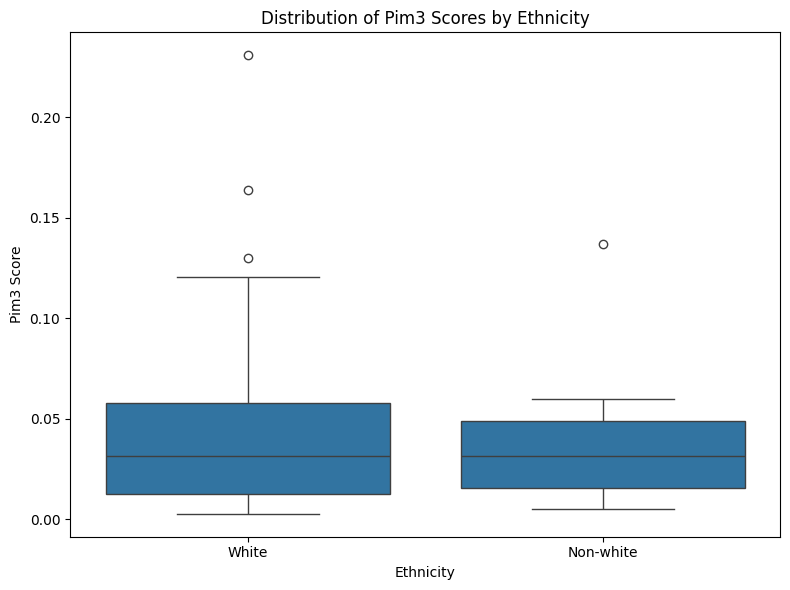

Mann-Whitney U test results:
Statistic: 183.0
P-value: 0.8447373699662459

Mean Pim3 score was 0.041 in White patients and 0.043 in Non-white patients.


In [ ]:
### 3.2 - Ethnicity vs Pim3 - Supplemntary Figure 1

# Create a new column 'ethnicity_grouped'
df['ethnicity_grouped'] = df['ethnicity'].apply(lambda x: 'White' if x == 1 else 'Non-white')
print("Supplementary Figure 1: Pim3 by Ethnicity")

# Create the box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='ethnicity_grouped', y='pim3', data=df)
plt.xlabel('Ethnicity')
plt.ylabel('Pim3 Score')
plt.title('Distribution of Pim3 Scores by Ethnicity')
plt.tight_layout()
plt.show()

# Perform Mann-Whitney U test
group_white = df[df['ethnicity_grouped'] == 'White']['pim3'].dropna()
group_non_white = df[df['ethnicity_grouped'] == 'Non-white']['pim3'].dropna()
statistic, p_value = mannwhitneyu(group_white, group_non_white)

# Print the results
print(f"Mann-Whitney U test results:")
print(f"Statistic: {statistic}")
print(f"P-value: {p_value}")

# Calculate and print the mean Pim3 scores for each group
mean_pim3_white = group_white.mean()
mean_pim3_non_white = group_non_white.mean()
print(f"\nMean Pim3 score was {mean_pim3_white:.3f} in White patients and {mean_pim3_non_white:.3f} in Non-white patients.")

In [ ]:
### 3.3 - SIMD in fatal vs. non-fatal - includes Supplementary Table 3

# 1. Drop rows with missing values in either 'simd' or 'alive' columns
df_cleaned = df.dropna(subset=['simd', 'alive'])

# 2. Create the contingency table
contingency_table = pd.crosstab(df_cleaned['alive'], df_cleaned['simd'])

# Display the contingency table
print("Supplementary Table 3: SIMD in fatal. vs non-fatal")
display(contingency_table)

# 3. Perform Chi-squared test
chi2_statistic, p_value, degrees_of_freedom, expected_frequencies = chi2_contingency(contingency_table)

# Print the results
print("\nChi-squared Test Results:")
print(f"Chi-squared statistic: {chi2_statistic}")
print(f"P-value: {p_value}")
print(f"Degrees of freedom: {degrees_of_freedom}")

Supplementary Table 3: SIMD in fatal. vs non-fatal


simd   1.0  2.0  3.0  4.0  5.0
alive                         
0.0      8    3    2    5    2
1.0     21   11   10   10    8


Chi-squared Test Results:
Chi-squared statistic: 1.3320197044334976
P-value: 0.8559199746285884
Degrees of freedom: 4


In [ ]:
### 3.4 - SIMD quintiles for whole population

# 1. Calculate observed frequencies (raw counts), ignoring "NA" values
observed_frequencies = df['simd'].value_counts(dropna=True)
observed_frequencies = observed_frequencies.sort_index()

# 2. Calculate total observed count
total_observed = observed_frequencies.sum()

# 3. Create expected frequencies (data in ScotlandPICUiGAS-EthnicityAndSIMDNormalisation)
expected_frequencies = pd.read_csv(io.StringIO('''
simd,count
1,"202,606"
2,"177,584"
3,"169,989"
4,"177,501"
5,"186,944"
'''), header=0, index_col='simd')
expected_frequencies = pd.to_numeric(expected_frequencies['count'].str.replace(',', ''))

# 4. Create the contingency table
contingency_table = pd.DataFrame({'Observed': observed_frequencies, 'Expected': expected_frequencies})

# Calculate percentages and cumulative percentages
contingency_table['Observed %'] = (contingency_table['Observed'] / total_observed) * 100
contingency_table['Expected %'] = (contingency_table['Expected'] / expected_frequencies.sum()) * 100
contingency_table['Observed Cumulative %'] = contingency_table['Observed %'].cumsum()
contingency_table['Expected Cumulative %'] = contingency_table['Expected %'].cumsum()

# Display the table
print("Contingency Table with Percentages and Cumulative Percentages:")
display(contingency_table)

# 5. Perform Chi-squared test
chi2_statistic, p_value, degrees_of_freedom, expected_array = chi2_contingency(contingency_table[['Observed', 'Expected']])

# Print the results
print("\nChi-squared Test Results:")
print(f"Chi-squared statistic: {chi2_statistic}")
print(f"P-value: {p_value}")
print(f"Degrees of freedom: {degrees_of_freedom}")

Contingency Table with Percentages and Cumulative Percentages:


Observed  Expected  Observed %  Expected %  Observed Cumulative %  \
simd                                                                      
1.0         29    202606       36.25   22.151835                  36.25   
2.0         14    177584       17.50   19.416066                  53.75   
3.0         12    169989       15.00   18.585670                  68.75   
4.0         15    177501       18.75   19.406991                  87.50   
5.0         10    186944       12.50   20.439437                 100.00   

      Expected Cumulative %  
simd                         
1.0               22.151835  
2.0               41.567901  
3.0               60.153571  
4.0               79.560563  
5.0              100.000000


Chi-squared Test Results:
Chi-squared statistic: 10.366478331998639
P-value: 0.03468677131093755
Degrees of freedom: 4


In [ ]:
### 3.5A - Ethnicity for whole cohort - includes Supplementary Table 4
### Compared to 2011 census

## Baseline data - see ScotlandPICUiGAS-EthnicityNormaisation Google Sheets for derivation

expected_ethnicity = pd.read_csv(io.StringIO('''
ethnicity,number
1,863005
2,9273
3,31449
4,9097
5,3507
'''), header=0)

# 1. Get observed frequencies from df
observed_frequencies = df['ethnicity'].value_counts().sort_index()

# 2. Get expected frequencies from expected_ethnicity DataFrame
expected_frequencies = expected_ethnicity['number'].values

# 3. Create contingency table
contingency_table = pd.DataFrame({'Observed': observed_frequencies, 'Expected': expected_frequencies})
contingency_table.index = contingency_table.index.astype(int)
contingency_table = contingency_table.sort_index()

# Display contingency table
print("Supplementary Table 4: Ethnicity in whole cohort *** compared to 2011 census ***")
display(contingency_table)

# 4. Perform Chi-squared test
chi2_statistic, p_value, degrees_of_freedom, expected_array = chi2_contingency(contingency_table[['Observed', 'Expected']])

# Print results
print("\nChi-squared Test Results for total ethnicty distrubution:")
print(f"Chi-squared statistic: {chi2_statistic}")
print(f"P-value: {p_value}")
print(f"Degrees of freedom: {degrees_of_freedom}")

# 5. Sum ethnicities 2-5 into 'Non-white' category
contingency_table_grouped = pd.DataFrame({
    'Observed': [contingency_table.loc[1, 'Observed'], contingency_table.loc[2:5, 'Observed'].sum()],
    'Expected': [contingency_table.loc[1, 'Expected'], contingency_table.loc[2:5, 'Expected'].sum()]
}, index=['White', 'Non-white'])

# Display grouped contingency table
print("Grouped Contingency Table:")
display(contingency_table_grouped)

# 6. Perform Chi-squared test on grouped table
chi2_statistic, p_value, degrees_of_freedom, expected_array = chi2_contingency(contingency_table_grouped[['Observed', 'Expected']])

# Print results
print("\nChi-squared Test Results - grouped white vs. non-white):")
print(f"Chi-squared statistic: {chi2_statistic}")
print(f"P-value: {p_value}")
print(f"Degrees of freedom: {degrees_of_freedom}")


Supplementary Table 4: Ethnicity in whole cohort *** compared to 2011 census ***


Observed  Expected
ethnicity                    
1                69    863005
2                 4      9273
3                 4     31449
4                 1      9097
5                 4      3507


Chi-squared Test Results for total ethnicty distrubution:
Chi-squared statistic: 56.771692937720374
P-value: 1.381407213974414e-11
Degrees of freedom: 4
Grouped Contingency Table:


Observed  Expected
White            69    863005
Non-white        13     53326


Chi-squared Test Results - grouped white vs. non-white):
Chi-squared statistic: 13.28513603015517
P-value: 0.00026751861925283777
Degrees of freedom: 1


In [ ]:
### 3.5B - Ethnicity for whole cohort - includes Supplementary Table 4
### compared to 2022 census ###

## Baseline data - see ScotlandPICUiGAS-EthnicityNormaisation Google Sheets for derivation

expected_ethnicity = pd.read_csv(io.StringIO('''
ethnicity,number
1,785878
2,19680
3,48888
4,24880
5,11924
'''), header=0)

# 1. Get observed frequencies from df
observed_frequencies = df['ethnicity'].value_counts().sort_index()

# 2. Get expected frequencies from expected_ethnicity DataFrame
expected_frequencies = expected_ethnicity['number'].values

# 3. Create contingency table
contingency_table = pd.DataFrame({'Observed': observed_frequencies, 'Expected': expected_frequencies})
contingency_table.index = contingency_table.index.astype(int)
contingency_table = contingency_table.sort_index()

# Display contingency table
print("Supplementary Table 4: Ethnicity in whole cohort *** compared to 2022 census ***")
display(contingency_table)

# 4. Perform Chi-squared test
chi2_statistic, p_value, degrees_of_freedom, expected_array = chi2_contingency(contingency_table[['Observed', 'Expected']])

# Print results
print("\nChi-squared Test Results for total ethnicty distrubution:")
print(f"Chi-squared statistic: {chi2_statistic}")
print(f"P-value: {p_value}")
print(f"Degrees of freedom: {degrees_of_freedom}")

# 5. Sum ethnicities 2-5 into 'Non-white' category
contingency_table_grouped = pd.DataFrame({
    'Observed': [contingency_table.loc[1, 'Observed'], contingency_table.loc[2:5, 'Observed'].sum()],
    'Expected': [contingency_table.loc[1, 'Expected'], contingency_table.loc[2:5, 'Expected'].sum()]
}, index=['White', 'Non-white'])

# Display grouped contingency table
print("Grouped Contingency Table:")
display(contingency_table_grouped)

# 6. Perform Chi-squared test on grouped table
chi2_statistic, p_value, degrees_of_freedom, expected_array = chi2_contingency(contingency_table_grouped[['Observed', 'Expected']])

# Print results
print("\nChi-squared Test Results - grouped white vs. non-white):")
print(f"Chi-squared statistic: {chi2_statistic}")
print(f"P-value: {p_value}")
print(f"Degrees of freedom: {degrees_of_freedom}")



Supplementary Table 4: Ethnicity in whole cohort *** compared to 2022 census ***


Observed  Expected
ethnicity                    
1                69    785878
2                 4     19680
3                 4     48888
4                 1     24880
5                 4     11924


Chi-squared Test Results for total ethnicty distrubution:
Chi-squared statistic: 11.257495428996576
P-value: 0.02381756822694526
Degrees of freedom: 4
Grouped Contingency Table:


Observed  Expected
White            69    785878
Non-white        13    105372


Chi-squared Test Results - grouped white vs. non-white):
Chi-squared statistic: 0.9203687294845673
P-value: 0.33737817457133734
Degrees of freedom: 1


In [ ]:
### 3.5C- Ethnicity for whole cohort - includes Supplementary Table 4
### compared to 2022 census BUT JUST 2022 CASES ###

## Baseline data - see ScotlandPICUiGAS-EthnicityNormaisation Google Sheets for derivation

expected_ethnicity = pd.read_csv(io.StringIO('''
ethnicity,number
1,785878
2,19680
3,48888
4,24880
5,11924
'''), header=0)

# 1. Get observed frequencies from df, ONLY for cases where season_start is 2022
observed_frequencies = df[df['season_start'] == 2022]['ethnicity'].value_counts().sort_index()

# 2. Ensure all 5 ethnicity categories are present in observed_frequencies, with 0 for missing ones
all_ethnicities = pd.Series(0, index=expected_ethnicity['ethnicity'])
all_ethnicities.update(observed_frequencies)
observed_frequencies = all_ethnicities

# 3. Get expected frequencies from expected_ethnicity DataFrame
expected_frequencies = expected_ethnicity['number'].values

# 4. Create contingency table
contingency_table = pd.DataFrame({'Observed': observed_frequencies, 'Expected': expected_frequencies})
contingency_table.index = contingency_table.index.astype(int)
contingency_table = contingency_table.sort_index()

# Display contingency table
print("Supplementary Table 4: Ethnicity in whole cohort *** compared to 2022 census and JUST 2022 cases***")
display(contingency_table)

# 4. Perform Chi-squared test
chi2_statistic, p_value, degrees_of_freedom, expected_array = chi2_contingency(contingency_table[['Observed', 'Expected']])

# Print results
print("\nChi-squared Test Results for total ethnicty distrubution:")
print(f"Chi-squared statistic: {chi2_statistic}")
print(f"P-value: {p_value}")
print(f"Degrees of freedom: {degrees_of_freedom}")

# 5. Sum ethnicities 2-5 into 'Non-white' category
contingency_table_grouped = pd.DataFrame({
    'Observed': [contingency_table.loc[1, 'Observed'], contingency_table.loc[2:5, 'Observed'].sum()],
    'Expected': [contingency_table.loc[1, 'Expected'], contingency_table.loc[2:5, 'Expected'].sum()]
}, index=['White', 'Non-white'])

# Display grouped contingency table
print("Grouped Contingency Table:")
display(contingency_table_grouped)

# 6. Perform Chi-squared test on grouped table
chi2_statistic, p_value, degrees_of_freedom, expected_array = chi2_contingency(contingency_table_grouped[['Observed', 'Expected']])

# Print results
print("\nChi-squared Test Results - grouped white vs. non-white):")
print(f"Chi-squared statistic: {chi2_statistic}")
print(f"P-value: {p_value}")
print(f"Degrees of freedom: {degrees_of_freedom}")

Supplementary Table 4: Ethnicity in whole cohort *** compared to 2022 census and JUST 2022 cases***


Observed  Expected
ethnicity                    
1                17    785878
2                 0     19680
3                 2     48888
4                 0     24880
5                 2     11924


Chi-squared Test Results for total ethnicty distrubution:
Chi-squared statistic: 12.314793482138512
P-value: 0.015157642635164953
Degrees of freedom: 4
Grouped Contingency Table:


Observed  Expected
White            17    785878
Non-white         4    105372


Chi-squared Test Results - grouped white vs. non-white):
Chi-squared statistic: 0.472574869633398
P-value: 0.4918049869957958
Degrees of freedom: 1


In [ ]:
########################
# Section 4 - Identification of iGAS
########################

Figure 2: Source of iGAS identification


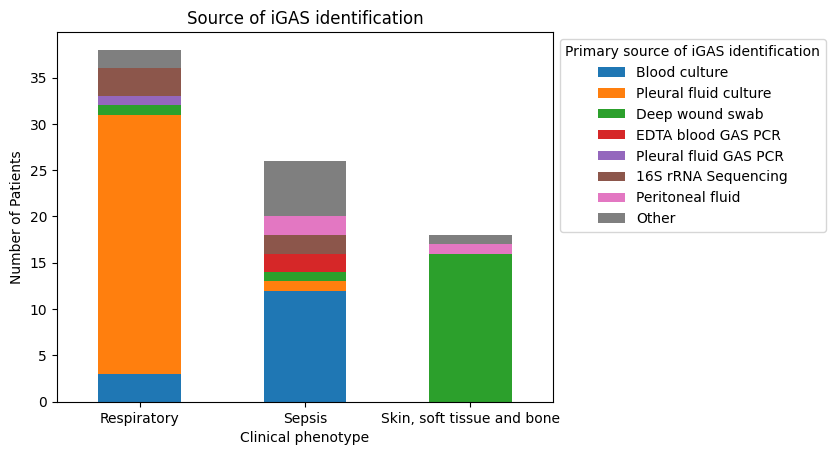

In [ ]:
### 4.1 - Source of iGAS identification - Includes Figure 2 ###

fig, ax = plt.subplots()
print("Figure 2: Source of iGAS identification")

df_phenotype = df.groupby(['source_gas_single', 'clinical_phen']).size().reset_index().pivot(columns='source_gas_single', index='clinical_phen', values=0)
df_phenotype.plot(kind='bar', stacked=True, ax=ax)
plt.legend(title="Primary source of iGAS identification", labels=['Blood culture', 'Pleural fluid culture', 'Deep wound swab', 'EDTA blood GAS PCR','Pleural fluid GAS PCR','16S rRNA Sequencing','Peritoneal fluid', 'Other'])

plt.xlabel('Clinical phenotype')
plt.ylabel('Number of Patients')
plt.title('Source of iGAS identification')
ax.set_xticklabels(['Respiratory', 'Sepsis', 'Skin, soft tissue and bone'])
plt.xticks(rotation=0)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
### 4.2 - Molecular methods numbers for text - Table S4

# Group data by season_start and source_gas_single, then count cases
source_gas_counts = df.groupby(['season_start', 'source_gas_single'])['source_gas_single'].count().unstack(fill_value=0)

# Select only columns 4, 5, 6
source_gas_counts = source_gas_counts[[4, 5, 6]]
total_sum = source_gas_counts.sum().sum()

# Calculate total for each year
source_gas_counts.loc['Total'] = source_gas_counts.sum()

# Rename columns for clarity
source_gas_counts = source_gas_counts.rename(columns={
    4: 'Blood PCR',
    5: 'Pleural PCR',
    6: '16S PCR',
})

# Display the table
print("Table S4 - Molecular Diagnostics")
display(source_gas_counts)

# For text description
percentage = (total_sum / df['study_number'].count()) * 100
print(f"Total sum of all entries in the table: {total_sum}")
print(f"Percentage of molecular diagnostics in the cohort: {percentage:.2f}%")

Table S4 - Molecular Diagnostics


source_gas_single  Blood PCR  Pleural PCR  16S PCR
season_start                                      
2013.0                     0            0        0
2014.0                     0            0        0
2015.0                     0            1        0
2016.0                     0            0        1
2017.0                     0            0        0
2018.0                     0            0        1
2019.0                     0            0        1
2020.0                     1            0        0
2021.0                     0            0        1
2022.0                     1            0        1
Total                      2            1        5

Total sum of all entries in the table: 8
Percentage of molecular diagnostics in the cohort: 9.76%


In [ ]:
### 4.3 - Probably omit this chart - was to check trends in molecular diagnostics

# Group data by season_start and source_gas_single, then calculate percentages
source_gas_percentages = df.groupby(['season_start', 'source_gas_single'])['source_gas_single'].count().unstack(fill_value=0)
source_gas_percentages = source_gas_percentages.div(source_gas_percentages.sum(axis=1), axis=0) * 100

# Select only columns 4, 5, 6, and calculate 'Other'
source_gas_percentages['Other'] = 100 - source_gas_percentages[[4, 5, 6]].sum(axis=1)
source_gas_percentages = source_gas_percentages[[4, 5, 6, 'Other']]

# Rename columns
source_gas_percentages = source_gas_percentages.rename(columns={
    4: 'EDTA blood GAS PCR',
    5: 'Pleural fluid GAS PCR',
    6: '16S PCR / rDNA sequencing',
})

# Create the stacked bar chart
ax = source_gas_percentages.plot(kind='bar', stacked=True, figsize=(10, 6))

# Display
plt.xlabel('Season Start')
plt.ylabel('Percentage of Cases')
plt.title('Percentage of Cases by Source of iGAS Identification per Season')
plt.legend(title='Source of iGAS Identification')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
########################
# Section 5 - Emm types
########################

In [ ]:
## 5.1 - Emm type by season and Supplementary Figure 2
#Emm type by season chart
import matplotlib.ticker as ticker

### Simplify the data so the categories are Emm1, Emm4, Emm12, Not typed and 16 Only
df['emm_type_combined'] = df['emm type']

# Now group
emm_type_mapping = {
    '1': '1',
    '4': '4',
    '12': '12',
    'Not typed': 'Not typed',
    '16S only': '16S only'
}

# Apply the mapping and create a new column
df['emm_type_grouped'] = df['emm_type_combined'].map(emm_type_mapping).fillna('Other Emm type')

# Group data by 'emm_type' and 'season_start'
emm_season_counts = df.groupby(['season_start', 'emm_type_grouped']).size().unstack(fill_value=0)

# Create the stacked bar chart
ax = emm_season_counts.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%d')) # Remove decimal points from y-axis
plt.xlabel('Season Start')

plt.ylabel('Number of Cases')
plt.title('Emm types by Season')
plt.grid(axis='y', color='gray', linestyle='--', linewidth=0.5)
plt.yticks(np.arange(0, 25, 5))

# Fix x-axis labels: Convert to integers
ax.set_xticks(range(len(emm_season_counts.index)))  # Ensure ticks align with bars
ax.set_xticklabels([f"{int(year)}" for year in emm_season_counts.index], rotation=45, ha="right")

plt.legend(title='Isolate Emm type')
plt.tight_layout()

print("Figure S3 - Emm types by season")
plt.show()

Figure S3 - Emm types by season


In [ ]:
### 5.2 - Calculations / text for above

### Emm type 1
# Calculate the percentage of cases with emm type 1 in 2022
emm_2022 = df[df['season_start'] == 2022]
emm1_count_2022 = len(emm_2022[emm_2022['emm_type_grouped'] == '1'])
total_emm_2022 = len(emm_2022)

percent_emm1_2022 = (emm1_count_2022 / total_emm_2022) * 100 if total_emm_2022 > 0 else 0

print("\n# Emm 1 text \n")
print(f"Percentage of emm type 1 cases in 2022: {percent_emm1_2022:.2f}%")

# Calculate the percentage of cases with emm type 1 for 2013-2019
percent_emm1_per_year = []
for year in range(2013, 2020):
  emm_year = df[df['season_start'] == year]
  emm1_count_year = len(emm_year[emm_year['emm_type_grouped'] == '1'])
  total_emm_year = len(emm_year)
  percent_emm1_year = (emm1_count_year / total_emm_year) * 100 if total_emm_year > 0 else 0
  percent_emm1_per_year.append(percent_emm1_year)

# Calculate average and range
avg_percent_emm1 = np.mean(percent_emm1_per_year)

print(f"Average percentage of emm type 1 cases (2013-2019): {avg_percent_emm1:.2f}%")
print(f"Min of percentage of emm type 1 cases (2013-2019): {np.min(percent_emm1_per_year)}")
print(f"Max of percentage of emm type 1 cases (2013-2019): {np.max(percent_emm1_per_year)}")

### Emm 12

# Calculate the percentage of cases with emm type 12 in 2022
emm12_count_2022 = len(emm_2022[emm_2022['emm_type_grouped'] == '12'])
percent_emm12_2022 = (emm12_count_2022 / total_emm_2022) * 100 if total_emm_2022 > 0 else 0

print("\n# Emm 12 data \n")
print(f"Percentage of emm type 12 cases in 2022: {percent_emm12_2022:.2f}%")

# Calculate the percentage of cases with emm type 12 for 2013-2019
percent_emm12_per_year = []
for year in range(2013, 2020):
  emm_year = df[df['season_start'] == year]
  emm12_count_year = len(emm_year[emm_year['emm_type_grouped'] == '12'])
  total_emm_year = len(emm_year)
  percent_emm12_year = (emm12_count_year / total_emm_year) * 100 if total_emm_year > 0 else 0
  percent_emm12_per_year.append(percent_emm12_year)

# Calculate average and range
avg_percent_emm12 = np.mean(percent_emm12_per_year)

print(f"Average percentage of emm type 12 cases (2013-2019): {avg_percent_emm12:.2f}%")
print(f"Min of percentage of emm type 12 cases (2013-2019): {np.min(percent_emm12_per_year)}")
print(f"Max of percentage of emm type 12 cases (2013-2019): {np.max(percent_emm12_per_year)}")

##### Was increase in Emm1 statistically signifiant?

#### For TYPED Emm types, is Emm1 more common than expected in 2022 vs. trend
# Create a list of Emm types to combine
emm_types_to_combine = ['4', '12', 'Other Emm type']

# Combine the specified Emm into the Other Emm Type group
df['emm1_vs_others'] = df['emm_type_grouped'].apply(lambda x: 'Other Emm type' if x in emm_types_to_combine else x)

#Emm 1 vs Non-Emm 2022
emm1_2022 = df[(df['season_start'] == 2022) & (df['emm1_vs_others'] == '1')]['emm1_vs_others'].count()
non_emm1_2022 = df[(df['season_start'] == 2022) & (df['emm1_vs_others'] == 'Other Emm type')]['emm1_vs_others'].count()

# Emm1 vs Non-Emm1 in 2013-2019
emm1_pre_2020 = df[(df['season_start'] < 2020) & (df['emm1_vs_others'] == '1')]['emm1_vs_others'].count()
non_emm1_pre_2020 = df[(df['season_start'] < 2020) & (df['emm1_vs_others'] == 'Other Emm type')]['emm1_vs_others'].count()

contingency_table = [[emm1_2022, non_emm1_2022],
                    [emm1_pre_2020, non_emm1_pre_2020]]

# Perform Chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print
print("\n# Was Emm1 significantly enriched in 2022? - note manually sense checked 2/1/24 - confusing because PCR not counted since we don't know a type, but these sums are correct\n")

print("\n# Contingency table\n")

print(contingency_table)

print("\n# Stats\n")

print(f"Chi-squared statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print(f"Expected frequencies: {expected}")


# Emm 1 text 

Percentage of emm type 1 cases in 2022: 71.43%
Average percentage of emm type 1 cases (2013-2019): 38.78%
Min of percentage of emm type 1 cases (2013-2019): 22.22222222222222
Max of percentage of emm type 1 cases (2013-2019): 50.0

# Emm 12 data 

Percentage of emm type 12 cases in 2022: 9.52%
Average percentage of emm type 12 cases (2013-2019): 10.43%
Min of percentage of emm type 12 cases (2013-2019): 0.0
Max of percentage of emm type 12 cases (2013-2019): 33.33333333333333

# Was Emm1 significantly enriched in 2022? - note manually sense checked 2/1/24 - confusing because PCR not counted since we don't know a type, but these sums are correct


# Contingency table

[[15, 2], [21, 25]]

# Stats

Chi-squared statistic: 7.534287084398977
P-value: 0.00605356864871041
Degrees of freedom: 1
Expected frequencies: [[ 9.71428571  7.28571429]
 [26.28571429 19.71428571]]



# Figure S3 - Emm type by phenotype



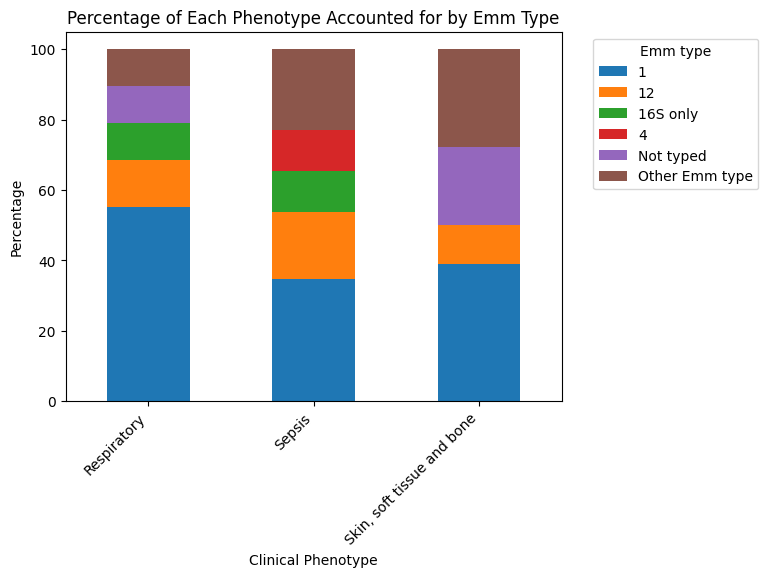


# Text summary

Percentage of Emm1 in phenotype 1.0: 56.76%
Percentage of Emm1 in phenotype 2.0: 24.32%
Percentage of Emm1 in phenotype 3.0: 18.92%

# Was respiratory enriched in Emm1 types?



emm_type_grouped   1  12  16S only  4  Not typed  Other Emm type
clinical_phen                                                   
1.0               21   5         4  0          4               4
2.0                9   5         3  3          0               6
3.0                7   2         0  0          4               5

emm_type_grouped   1  12  16S only  4  Not typed  Other Emm type
clinical_phen                                                   
1.0               21   5         4  0          4               4
2.0                9   5         3  3          0               6
3.0                7   2         0  0          4               5

Test results

Chi-squared statistic: 18.581109391635707
P-value: 0.04591734159273679
Degrees of freedom: 10
Expected frequencies: [[17.14634146  5.56097561  3.24390244  1.3902439   3.70731707  6.95121951]
 [11.73170732  3.80487805  2.2195122   0.95121951  2.53658537  4.75609756]
 [ 8.12195122  2.63414634  1.53658537  0.65853659  1.75609756  3.29268293]]


In [ ]:
### 5.3 - Emm type by phenotype - includes Figure S3###

# Group and calculate percentages
phenotype_emm_percentages = df.groupby(['clinical_phen', 'emm_type_grouped']).size().groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).unstack()

# Plotting
print("\n# Figure S3 - Emm type by phenotype\n")
ax = phenotype_emm_percentages.plot(kind='bar', stacked=True)
plt.ylabel('Percentage')
plt.xlabel('Clinical Phenotype')
plt.title('Percentage of Each Phenotype Accounted for by Emm Type')
plt.legend(title="Emm type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
ax.set_xticklabels(['Respiratory', 'Sepsis', 'Skin, soft tissue and bone'])
plt.show()

### Text

# Calculate percentages
phenotype_emm1_percentages = df[df['emm_type_grouped'] == '1']['clinical_phen'].value_counts(normalize=True) * 100

# Print the percentages
print("\n# Text summary\n")
for phenotype, percentage in phenotype_emm1_percentages.items():
    print(f"Percentage of Emm1 in phenotype {phenotype}: {percentage:.2f}%")

### Stats

print("\n# Was respiratory enriched in Emm1 types?\n")

# Create a contingency table with all Emm types
contingency_table = pd.crosstab(df['clinical_phen'], df['emm_type_grouped'])
display(contingency_table)
print(contingency_table)
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("\nTest results\n")
print(f"Chi-squared statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print(f"Expected frequencies: {expected}")

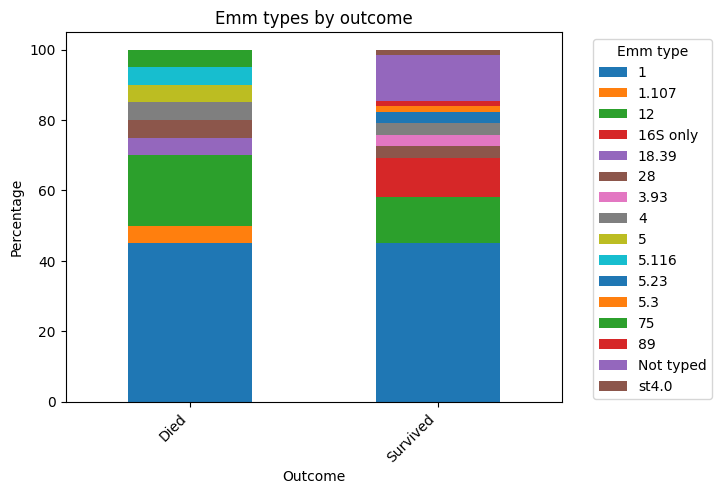

In [ ]:
### 5.4 - probably omit - Emm type by outcome ###

# Group and calculate percentages
emm_type_outcome = df.groupby(['alive', 'emm type']).size().groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).unstack()

# Plotting
ax = emm_type_outcome.plot(kind='bar', stacked=True)
plt.ylabel('Percentage')
plt.xlabel('Outcome')
plt.title('Emm types by outcome')
plt.legend(title="Emm type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
ax.set_xticklabels(['Died', 'Survived'])
plt.show()

In [ ]:
########################
# Section 6 - Viral infections
########################

In [ ]:
##6.1 - Setting up viral tables and Supplementary Table 5
#need varicella seperate due to the extra category of a clinical diagnosis
#this is overly detailed but helps to visualise the data in the DataFrame

virus_list =["rsv", "hmpv", "rhino", "influenza",   "adeno",    "parainfluenza", "bocavirus", "coronavirus"]
viral_df = pd.DataFrame(columns=['virus', 'number_cases', 'number_tested', 'percent_tested', 'number_positive', 'percent_tests_positive', 'percent_cases_positive'])
for virus in virus_list:
  number_positive = df[virus].value_counts()[1]
  percent_positive = number_positive / df[virus].count()
  number_tested = (df[virus].value_counts()[0] + df[virus].value_counts()[1]) #positive and negative tests
  percent_tested = (number_tested / df[virus].count()) * 100 #negative (0) and positive (1) tests, over total
  percent_tests_positive = (df[virus].value_counts()[1] / number_tested) * 100 #positive tests over total
  percent_cases_positive = (df[virus].value_counts()[1] / df[virus].count()) * 100
  viral_df = pd.concat([viral_df, pd.DataFrame({'virus': [virus], 'number_cases': [df[virus].count()], 'number_tested': [number_tested], 'percent_tested': [percent_tested], 'number_positive': [number_positive], 'percent_tests_positive': [percent_tests_positive], 'percent_cases_positive': [percent_cases_positive]})], ignore_index=True)

# Round for readibility
viral_df['percent_tested'] = viral_df['percent_tested'].round(2)
viral_df['percent_tests_positive'] = viral_df['percent_tests_positive'].round(2)
viral_df['percent_cases_positive'] = viral_df['percent_cases_positive'].round(2)

print("\n# Supplementary Table 5 \n")

display(viral_df)


# Supplementary Table 5 



<ipython-input-5-6c71317054dd>:14: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



virus number_cases number_tested  percent_tested number_positive  \
0            rsv           82            66           80.49               6   
1           hmpv           82            61           74.39              16   
2          rhino           82            63           76.83              18   
3      influenza           82            67           81.71               3   
4          adeno           82            63           76.83               9   
5  parainfluenza           82            63           76.83               3   
6      bocavirus           82            41           50.00               2   
7    coronavirus           58            39           67.24               3   

   percent_tests_positive  percent_cases_positive  
0                    9.09                    7.32  
1                   26.23                   19.51  
2                   28.57                   21.95  
3                    4.48                    3.66  
4                   14.29                   10.98  
5                    4.76                    3.66  
6                    4.88                    2.44  
7                    7.69                    5.17


# Supplementary Figure 4 



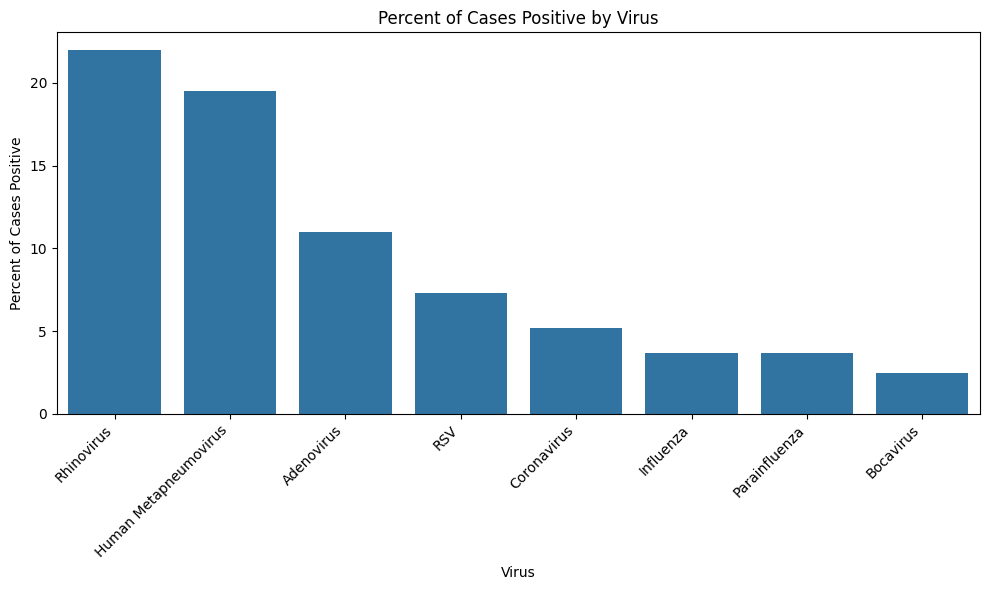

In [ ]:
##6.2 - Most common positive viruses - Supplementary Figure 4

#First rename the viruses
virus_name_mapping = {
    'rhino': 'Rhinovirus',
    'rsv': 'RSV',
    'hmpv': 'Human Metapneumovirus',
    'influenza': 'Influenza',
    'adeno': 'Adenovirus',
    'parainfluenza': 'Parainfluenza',
    'bocavirus': 'Bocavirus',
    'coronavirus': 'Coronavirus'
}
viral_df['virus'] = viral_df['virus'].replace(virus_name_mapping)

#Now chart
print("\n# Supplementary Figure 4 \n")
viral_df_sorted = viral_df.sort_values(by='percent_cases_positive', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='virus', y='percent_cases_positive', data=viral_df_sorted)
plt.xlabel('Virus')
plt.ylabel('Percent of Cases Positive')
plt.title('Percent of Cases Positive by Virus')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


# Test postivity rates by virus and season 




# Supplementary Figure 5 



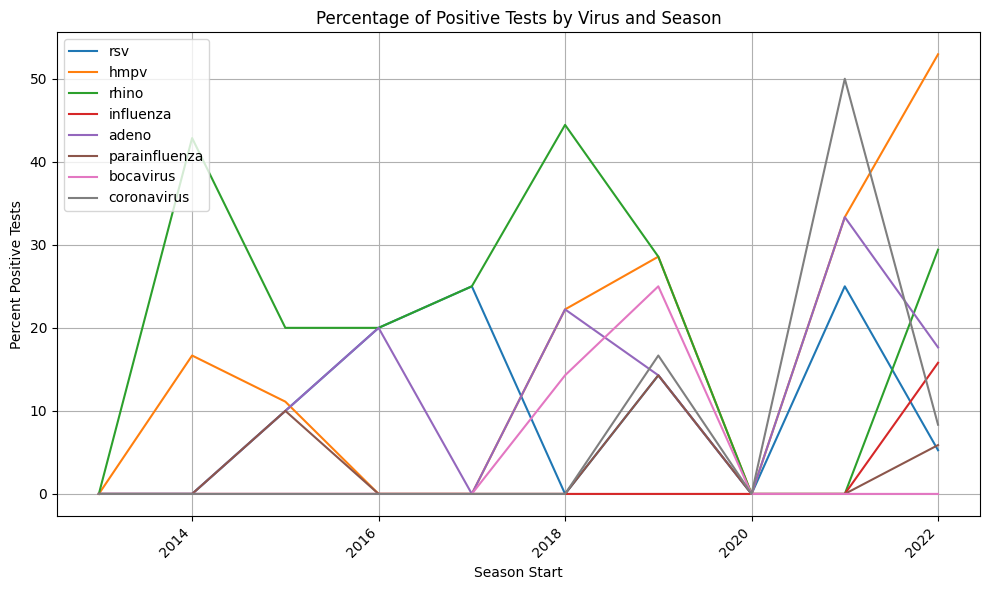

Average value of hmpv for seasons 2013-2019: 11.22
Average value of rhino for seasons 2013-2019: 25.84


In [ ]:
##6.3 - % positive tests per season - Supplementary Figure 5
virus_list = ["rsv", "hmpv", "rhino", "influenza", "adeno", "parainfluenza", "bocavirus", "coronavirus"]

# Create an empty dictionary to store the results
results = {}

# Iterate over each virus in the virus_list
for virus in virus_list:
    # Group data by season_start and calculate percent_tests_positive for each season - eg, values of 1 (positive) over total of values (0 and 1) as other mean not tested
    season_data = df.groupby('season_start')[virus].apply(lambda x: (x[x == 1].count() / x[(x == 0) | (x == 1)].count()) * 100 if x[(x == 0) | (x == 1)].count() > 0 else 0).reset_index()

    # Add the results to the dictionary with the virus name as the key
    results[virus] = season_data

# 1. Create a list of DataFrames, each with 'season_start' and one virus column:
dfs = []
for virus in virus_list:
    dfs.append(results[virus][['season_start', virus]])  # Select only 'season_start' and the virus column

# 2. Merge the DataFrames on 'season_start':
from functools import reduce
final_table = reduce(lambda left, right: pd.merge(left, right, on='season_start', how='outer'), dfs)

print("\n# Test postivity rates by virus and season \n")
display(final_table.style.format("{:.2f}"))

###  Chart
# Get a list of unique viruses from the table columns (excluding 'season_start')
viruses = [col for col in final_table.columns if col != 'season_start']

# Set up the plot
plt.figure(figsize=(10, 6))  # Adjust figure size if needed

# Iterate over each virus and plot the line - need to use the `viruses` variable created above, not `virus_list`
for virus in viruses:
    plt.plot(final_table['season_start'], final_table[virus], label=virus)

# Ouput
print("\n# Supplementary Figure 5 \n")
plt.xlabel('Season Start')
plt.ylabel('Percent Positive Tests')
plt.title('Percentage of Positive Tests by Virus and Season')
plt.legend()  # Display legend to identify lines
plt.grid(True)  # Add grid for better readability
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout() #adjust layout to prevent labels from overlapping
plt.show()

## Additional text output
# Filter data for seasons 2013-2019
filtered_data = final_table[final_table['season_start'].between(2013, 2019)]

# Calculate the average value of 'hmpv'
average_hmpv = filtered_data['hmpv'].mean()
average_rhino = filtered_data['rhino'].mean()

# Display the average value
print(f"Average value of hmpv for seasons 2013-2019: {average_hmpv:.2f}")
print(f"Average value of rhino for seasons 2013-2019: {average_rhino:.2f}")


# Figure 3A - test positivity rates pre- and post-Covid19 lockdowns 



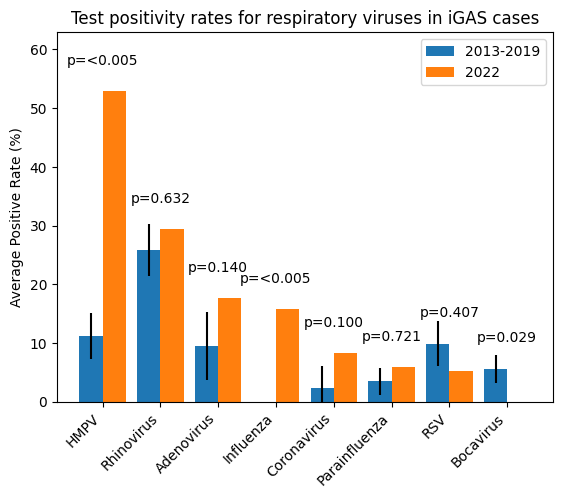

Fischer exact test for 'hmpv':
Statistic: 0.11298076923076923
P-value: 3.403145968491899e-10

Fischer exact test for 'rhino':
Statistic: 0.8154706430568499
P-value: 0.632380410560478

Fischer exact test for 'adeno':
Statistic: 0.4823529411764706
P-value: 0.13967774454009266

Fischer exact test for 'influenza':
Statistic: 0.0
P-value: 1.5912973462727138e-05

Fischer exact test for 'coronavirus':
Statistic: 0.2345360824742268
P-value: 0.10045546506438677

Fischer exact test for 'parainfluenza':
Statistic: 0.5875
P-value: 0.7208801126426698

Fischer exact test for 'rsv':
Statistic: 1.88
P-value: 0.40658288239826645

Fischer exact test for 'bocavirus':
Statistic: inf
P-value: 0.028930282023157568



In [ ]:
### 6.4 - Figure 3A - test positivity rates pre- and post-Covid19 lockdowns, with p values based on OR

# Calculate average positive rates for 2013-2019
pre_2020_data = final_table[final_table['season_start'].isin(range(2013, 2020))]
avg_positive_rates_pre_2020 = pre_2020_data.drop(columns=['season_start']).mean()
#Calculate SE
standard_errors = pre_2020_data.drop(columns=['season_start']).std() / np.sqrt(len(pre_2020_data))

# Get positive rate for 2022 and sort based on this
positive_rates_2022 = final_table[final_table['season_start'] == 2022].drop(columns=['season_start']).iloc[0]
positive_rates_2022 = positive_rates_2022.sort_values(ascending=False)  # Sort by 2022 rate

# Reorder pre-2020 data based on sorted 2022 data
viruses = positive_rates_2022.index  # Get virus names based on sorted order
avg_positive_rates_pre_2020 = avg_positive_rates_pre_2020[viruses]  # Reorder pre-2020 data

# Create bar chart
viruses = avg_positive_rates_pre_2020.index  # Get virus names
x_pos = np.arange(len(viruses))  # X positions for bars

# Create bars for 2013-2019
plt.bar(x_pos - 0.2, avg_positive_rates_pre_2020, yerr=standard_errors, width=0.4, label='2013-2019')

# Create bars for 2022
plt.bar(x_pos + 0.2, positive_rates_2022, width=0.4, label='2022')

# Formatting
plt.xticks(x_pos, viruses, rotation=45, ha='right')  # Set x-axis labels
plt.ylabel('Average Positive Rate (%)')
plt.title('Test positivity rates for respiratory viruses in iGAS cases')
plt.legend()

### Now add statistics

# Add p-value annotations
# Get list of viruses
viruses = avg_positive_rates_pre_2020.index

# Add some vertical space for annotations
y_max = max(max(avg_positive_rates_pre_2020), max(positive_rates_2022))
plt.ylim(0, y_max + 10)

# Loop through viruses and perform tests and add annotations
for i, virus in enumerate(viruses):
    # Create contingency table
    contingency_table = pd.DataFrame({
        'Year': ['2013-2019', '2022'],
        'Positive': [avg_positive_rates_pre_2020[virus], positive_rates_2022[virus]],
        'Negative': [100 - avg_positive_rates_pre_2020[virus], 100 - positive_rates_2022[virus]]
    })

    # Perform Fisher's exact test
    oddsratio, p_value = fisher_exact(contingency_table[['Positive', 'Negative']])
    #If <0.0005 just say this
    if p_value < 0.0005:
        p_value ="<0.005"
    else: p_value = f"{p_value:.3f}"

    # Add p-value annotation
    # Calculate x and y positions for annotation
    x_coord = x_pos[i]
    y_coord = max(avg_positive_rates_pre_2020[virus], positive_rates_2022[virus]) + 4

    #Rename x ticks
    virus_name_mapping = {
      'rhino': 'Rhinovirus',
      'rsv': 'RSV',
      'hmpv': 'HMPV',
      'influenza': 'Influenza',
      'adeno': 'Adenovirus',
      'parainfluenza': 'Parainfluenza',
      'bocavirus': 'Bocavirus',
      'coronavirus': 'Coronavirus'
    }

    #Get renamed tick labels and change x-label
    renamed_ticks = [virus_name_mapping.get(virus, virus) for virus in viruses]
    plt.xticks(x_pos, renamed_ticks, rotation=45, ha='right')

    # Add p value annotation
    plt.text(x_coord, y_coord, "p=" + str(p_value), ha='center', va='bottom')

print("\n# Figure 3A - test positivity rates pre- and post-Covid19 lockdowns \n")
plt.show()

#### Print out the statistics instead

# Get list of viruses
viruses = avg_positive_rates_pre_2020.index

# Loop through viruses and perform tests
for virus in viruses:
    # Create contingency table
    contingency_table = pd.DataFrame({
        'Year': ['2013-2019', '2022'],
        'Positive': [avg_positive_rates_pre_2020[virus], positive_rates_2022[virus]],
        'Negative': [100 - avg_positive_rates_pre_2020[virus], 100 - positive_rates_2022[virus]]
    })

    #Perform test - using Fisher's as some have <5 data points
    oddsratio, p_value = fisher_exact(contingency_table[['Positive', 'Negative']]) # Change here

    # Print results
    print(f"Fischer exact test for '{virus}':")
    print(f"Statistic: {oddsratio}")
    print(f"P-value: {p_value}\n")

In [ ]:
### 6.5 - is increased positivity rate for HMPV signficant? ###

# Filter data for 2022 and pre-2020
df_2022 = df[df['season_start'] == 2022]
df_pre_2020 = df[df['season_start'] < 2020]

# Create contingency table
contingency_table = pd.DataFrame({
    'Year': ['2022', 'Pre-2020'],
    'HMPV Positive': [df_2022['hmpv'].value_counts().get(1, 0), df_pre_2020['hmpv'].value_counts().get(1, 0)],
    'HMPV Negative': [df_2022['hmpv'].value_counts().get(0, 0), df_pre_2020['hmpv'].value_counts().get(0, 0)]
})

# Display the table
print(contingency_table)

# Perform Chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table[['HMPV Positive', 'HMPV Negative']])

# Print the results
print(f"Chi-squared statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print(f"Expected frequencies: {expected}")

       Year  HMPV Positive  HMPV Negative
0      2022              9              8
1  Pre-2020              6             35
Chi-squared statistic: 7.307846473813577
P-value: 0.00686541551856949
Degrees of freedom: 1
Expected frequencies: [[ 4.39655172 12.60344828]
 [10.60344828 30.39655172]]


In [ ]:
### 6.6 - was there increased testing for HMPV? ###

# Create a new column indicating whether HMPV was tested (0 or 1)
df['hmpv_tested'] = df['hmpv'].apply(lambda x: 1 if x in [0, 1] else 0)

# Filter data for 2022 and pre-2020
df_2022 = df[df['season_start'] == 2022]
df_pre_2020 = df[df['season_start'] < 2020]

# Create contingency table
contingency_table = pd.DataFrame({
    'Year': ['2022', 'Pre-2020'],
    'HMPV Tested': [df_2022['hmpv_tested'].sum(), df_pre_2020['hmpv_tested'].sum()],
    'HMPV Not Tested': [len(df_2022) - df_2022['hmpv_tested'].sum(), len(df_pre_2020) - df_pre_2020['hmpv_tested'].sum()]
})

# Display the contingency table
print("Contingency Table:")
print(contingency_table)

# Perform Chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table[['HMPV Tested', 'HMPV Not Tested']])

# Print the results
print("\nChi-squared Test Results:")
print(f"Chi-squared statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print(f"Expected frequencies: {expected}")

# Print text summary
print("\nText Summary:")

# Calculate and print testing rate for 2022
testing_rate_2022 = (df_2022['hmpv_tested'].sum() / len(df_2022)) * 100
print(f"In 2022, {df_2022['hmpv_tested'].sum()} out of {len(df_2022)} patients were tested for HMPV ({testing_rate_2022:.2f}%).")

# Calculate and print testing rate for pre-2020
testing_rate_pre_2020 = (df_pre_2020['hmpv_tested'].sum() / len(df_pre_2020)) * 100
print(f"In the years 2013-2019, {df_pre_2020['hmpv_tested'].sum()} out of {len(df_pre_2020)} patients were tested for HMPV ({testing_rate_pre_2020:.2f}%).")

Contingency Table:
       Year  HMPV Tested  HMPV Not Tested
0      2022           17                4
1  Pre-2020           41               14

Chi-squared Test Results:
Chi-squared statistic: 0.08168383340797125
P-value: 0.7750283689402394
Degrees of freedom: 1
Expected frequencies: [[16.02631579  4.97368421]
 [41.97368421 13.02631579]]

Text Summary:
In 2022, 17 out of 21 patients were tested for HMPV (80.95%).
In the years 2013-2019, 41 out of 55 patients were tested for HMPV (74.55%).


In [ ]:
### 6.7 - is increased positivity rate for adenovirus significant? ###

# Create contingency table
contingency_table = pd.DataFrame({
    'Year': ['2022', 'Pre-2020'],
    'Adeno Positive': [df_2022['adeno'].value_counts().get(1, 0), df_pre_2020['adeno'].value_counts().get(1, 0)],
    'Adeno Negative': [df_2022['adeno'].value_counts().get(0, 0), df_pre_2020['adeno'].value_counts().get(0, 0)]
})

# Display the table
print(contingency_table)

# Perform Chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table[['Adeno Positive', 'Adeno Negative']])

# Print the results
print(f"Chi-squared statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print(f"Expected frequencies: {expected}")

       Year  Adeno Positive  Adeno Negative
0      2022               3              14
1  Pre-2020               5              38
Chi-squared statistic: 0.03867199831632116
P-value: 0.844099896415416
Degrees of freedom: 1
Expected frequencies: [[ 2.26666667 14.73333333]
 [ 5.73333333 37.26666667]]


In [ ]:
### 6.8 - viruses by PIM3 score - Supplementary Figure 6 ###

######## Make summary column for the virus status ######
#Numerical code where 0 is positive for none of below, (1-8) is single positive for one of below and 9 is positive for multiple viruses
virus_name_mapping = {
    'rhino': '1',
    'rsv': '2',
    'hmpv': '3',
    'influenza': '4',
    'adeno': '5',
    'parainfluenza': '6',
    'bocavirus': '7',
    'coronavirus': '8'
}

# Get the keys from the virus_name_mapping dictionary
virus_columns = list(virus_name_mapping.keys())

####### !!! Some viruses have values other than 0 or 1 which isn't in data dictionary - so if value not 1, make 0 (presumably other values are not tested etc)
df[virus_columns] = df[virus_columns].applymap(lambda x: 1 if x == 1 else 0)

# Create a new column 'viral_summary_code' and initialize with 0
df['viral_summary_code'] = 0

# Iterate over rows and update 'viral_summary_code' based on conditions
for index, row in df.iterrows():
    # Get the values of virus columns for the current row
    virus_values = row[virus_columns]

    # Check if all virus values are 0
    if virus_values.sum() == 0:
        continue  # Keep the initial value of 0

    # Check if more than one virus is positive
    elif virus_values[virus_values == 1].count() > 1:
        df.loc[index, 'viral_summary_code'] = 9

    # If only one virus is positive, assign the corresponding code
    else:
        positive_viruses = virus_values[virus_values == 1].index
        if len(positive_viruses) > 0:  # Check if there are any positive viruses
          positive_virus = positive_viruses[0]
          df.loc[index, 'viral_summary_code'] = int(virus_name_mapping[positive_virus])

# Graph
plt.figure(figsize=(12, 6))
sns.boxplot(x='viral_summary_code', y='pim3', data=df)

# Customise
plt.xlabel('Viral Summary Code')
plt.ylabel('Pim3 Score')
plt.title('Distribution of Pim3 Scores by respiratory virus positivity')

# Rename the x entries
viral_code_names = {
    0: 'No positive virology',
    1: 'Rhinovirus',
    2: 'RSV',
    3: 'Human Metapneumovirus',
    4: 'Influenza',
    5: 'Adenovirus',
    6: 'Parainfluenza',
    7: 'Bocavirus',
    8: 'Coronavirus',
    9: 'Multiple positive viruses'
}

plt.xlabel("Virus")
plt.xticks(
    ticks=plt.xticks()[0],  # Get current tick locations
    labels=[viral_code_names.get(code, code) for code in plt.xticks()[0]],  # Get labels from mapping
    rotation=45, ha='right'  # Rotate and align labels
)

plt.tight_layout()

print("\n# Supplementary Figure 6 - Pim3 values with different viruses \n")
plt.show()

#### Multiple comparison
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Perform one-way ANOVA
# Filter df to include only rows with non-missing values for both 'pim3' and 'viral_summary_code'
filtered_df = df[df['pim3'].notna() & df['viral_summary_code'].notna()]

# Get groups from filtered DataFrame
groups = [filtered_df['pim3'][filtered_df['viral_summary_code'] == code].dropna() for code in filtered_df['viral_summary_code'].unique()]

fvalue, pvalue = stats.f_oneway(*groups)

print(f"Overall ANOVA results:")
print(f"F-statistic: {fvalue}")
print(f"P-value: {pvalue}")

# Perform pairwise comparisons using Tukey's HSD
# Use filtered_df for pairwise comparisons
tukey_result = pairwise_tukeyhsd(filtered_df['pim3'], filtered_df['viral_summary_code'], alpha=0.05)

print("\nPairwise comparisons (Tukey's HSD):")
print(tukey_result)


<ipython-input-15-86ffc02f5539>:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[virus_columns] = df[virus_columns].applymap(lambda x: 1 if x == 1 else 0)



# Supplementary Figure 6 - Pim3 values with different viruses 



Overall ANOVA results:
F-statistic: 1.113885895644776
P-value: 0.3691330050813126

Pairwise comparisons (Tukey's HSD):
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1   0.0425  0.415 -0.0197 0.1046  False
     0      2    0.018    1.0 -0.1238 0.1599  False
     0      3   0.0377 0.4904 -0.0206  0.096  False
     0      4  -0.0188    1.0 -0.1606 0.1231  False
     0      5   0.0094    1.0 -0.0647 0.0835  False
     0      6  -0.0002    1.0  -0.142 0.1417  False
     0      8    0.029 0.9991 -0.1128 0.1709  False
     0      9   0.0034    1.0 -0.0493 0.0561  False
     1      2  -0.0244 0.9998 -0.1753 0.1264  False
     1      3  -0.0048    1.0 -0.0825 0.0729  False
     1      4  -0.0612 0.9233 -0.2121 0.0897  False
     1      5  -0.0331 0.9562 -0.1232 0.0571  False
     1      6  -0.0426 0.9912 -0.1935 0.1082  False
     1      8  -0.0134    1.0 -0.1643 0.1375  Fal

In [ ]:
### 6.9 - negative vs. positive virology Pim3 scores - Figure 3B ###

# Create a new column 'viral_group' to group the data
df['viral_group'] = df['viral_summary_code'].apply(lambda x: 'No respiratory viruses' if x == 0 else 'One or more respiratory viruses')

# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='viral_group', y='pim3', data=df)

# Customise graph
plt.xlabel('Viral Status')
plt.ylabel('Pim3 Score')
plt.title('Pim3 score by respiratory virus status')

plt.tight_layout()

print("\n# Figure 3B - Pim3 score by respiratory virus status \n")
plt.show()

### Stats
group_none = df[df['viral_group'] == 'No respiratory viruses']['pim3'].dropna()
group_any_virus = df[df['viral_group'] == 'One or more respiratory viruses']['pim3'].dropna()

# Perform Mann-Whitney U test
statistic, p_value = mannwhitneyu(group_none, group_any_virus)

# Print the results
print(f"Mann-Whitney U test results:")
print(f"Statistic: {statistic}")
print(f"P-value: {p_value}")

# Calculate and print the mean Pim3 scores for each viral group
mean_pim3_no_viruses = df[df['viral_group'] == 'No respiratory viruses']['pim3'].mean()
mean_pim3_any_virus = df[df['viral_group'] == 'One or more respiratory viruses']['pim3'].mean()

print(f"Mean Pim3 score for patients with no respiratory viruses: {mean_pim3_no_viruses:.2f}")
print(f"Mean Pim3 score for patients with one or more respiratory viruses: {mean_pim3_any_virus:.2f}")

# Calculate and print the number of observations for each viral group
n_no_viruses = df[df['viral_group'] == 'No respiratory viruses']['pim3'].count()
n_any_virus = df[df['viral_group'] == 'One or more respiratory viruses']['pim3'].count()

print(f"Number of observations with no respiratory viruses: {n_no_viruses}")
print(f"Number of observations with one or more respiratory viruses: {n_any_virus}")


# Figure 3B - Pim3 score by respiratory virus status 



Mann-Whitney U test results:
Statistic: 309.0
P-value: 0.016321464452146623
Mean Pim3 score for patients with no respiratory viruses: 0.03
Mean Pim3 score for patients with one or more respiratory viruses: 0.05
Number of observations with no respiratory viruses: 32
Number of observations with one or more respiratory viruses: 30


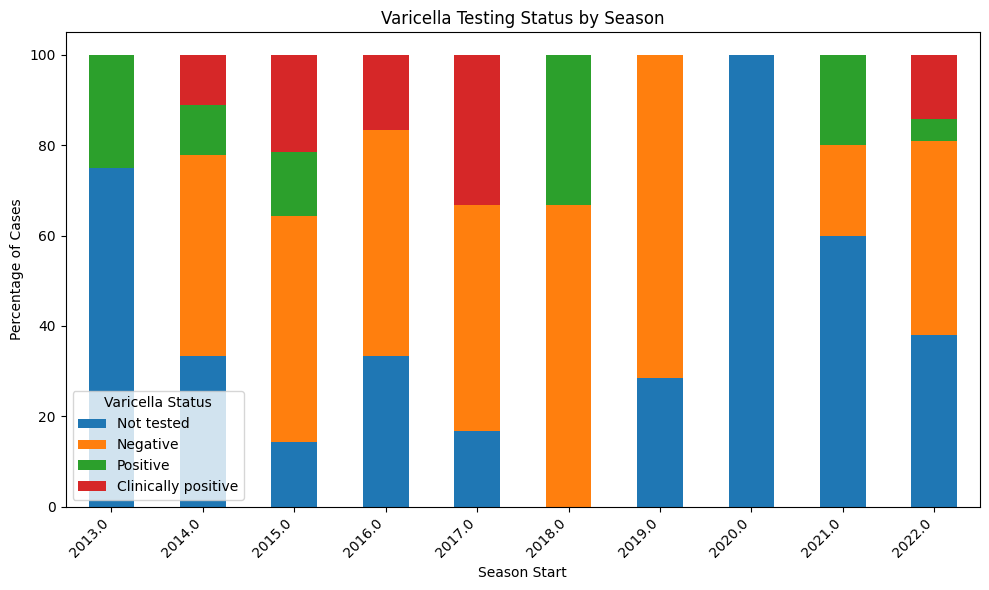

In [ ]:
### 6.10 - probably omit - VZV summary by season ###

# Combine values 2 and 3 into a single category
df['varicella_grouped'] = df['varicella'].replace({2: 'Not tested', 3: 'Not tested'})

# Group data by season_start and varicella_grouped, then calculate percentages
varicella_percentages = df.groupby(['season_start', 'varicella_grouped'])['varicella_grouped'].count().unstack(fill_value=0)
varicella_percentages = varicella_percentages.div(varicella_percentages.sum(axis=1), axis=0) * 100

# Reorder columns for better visualization
varicella_percentages = varicella_percentages[['Not tested', 0, 1, 4]]

# Rename columns for clarity
varicella_percentages = varicella_percentages.rename(columns={
    0: 'Negative',
    1: 'Positive',
    4: 'Clinically positive'
})

# Create the stacked bar chart
ax = varicella_percentages.plot(kind='bar', stacked=True, figsize=(10, 6))

# Customize the chart
plt.xlabel('Season Start')
plt.ylabel('Percentage of Cases')
plt.title('Varicella Testing Status by Season')
plt.legend(title='Varicella Status')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
### Cell 6.11 - VZV summary by season stats

## (1) testing rates

# Create a new column indicating whether varicella was tested
df['varicella_tested'] = df['varicella'].apply(lambda x: 1 if x in [0, 1] else 0)

# Filter data for 2022 and pre-2020
df_2022 = df[df['season_start'] == 2022]
df_pre_2020 = df[df['season_start'] < 2020]

# Create contingency table
testing_contingency_table = pd.DataFrame({
    'Year': ['2022', 'Pre-2020'],
    'Tested': [df_2022['varicella_tested'].sum(), df_pre_2020['varicella_tested'].sum()],
    'Not Tested': [len(df_2022) - df_2022['varicella_tested'].sum(), len(df_pre_2020) - df_pre_2020['varicella_tested'].sum()]
})

print("\n# VZV testing rates \n")

print("Contingency Table for Varicella Testing Rates:")
print(testing_contingency_table)

# Perform Chi-squared test for testing rates
chi2_statistic_testing, p_value_testing, dof_testing, expected_testing = chi2_contingency(testing_contingency_table[['Tested', 'Not Tested']])

print("\nChi-squared Test Results for Varicella Testing Rates:")
print(f"Chi-squared statistic: {chi2_statistic_testing}")
print(f"P-value: {p_value_testing}")
print(f"Degrees of freedom: {dof_testing}")

# Calculate and print testing rates for 2022 and pre-2020
testing_rate_2022 = (testing_contingency_table.loc[testing_contingency_table['Year'] == '2022', 'Tested'].iloc[0] / len(df_2022)) * 100
testing_rate_pre_2020 = (testing_contingency_table.loc[testing_contingency_table['Year'] == 'Pre-2020', 'Tested'].iloc[0] / len(df_pre_2020)) * 100

print(f"\nIn 2022, {testing_contingency_table.loc[testing_contingency_table['Year'] == '2022', 'Tested'].iloc[0]} out of {len(df_2022)} patients were tested for varicella ({testing_rate_2022:.2f}%).")
print(f"In the years 2013-2019, {testing_contingency_table.loc[testing_contingency_table['Year'] == 'Pre-2020', 'Tested'].iloc[0]} out of {len(df_pre_2020)} patients were tested for varicella ({testing_rate_pre_2020:.2f}%).")

## (2) postivite rates (clinical and proven)

# Create a new column indicating whether varicella was positive either by testing or clinical impression
df['varicella_positive'] = df['varicella'].apply(lambda x: 1 if x in [1, 4] else 0)

# Filter data for 2022 and pre-2020
df_2022 = df[df['season_start'] == 2022]
df_pre_2020 = df[df['season_start'] < 2020]

# Create contingency table
positive_contingency_table = pd.DataFrame({
    'Year': ['2022', 'Pre-2020'],
    'Positive': [df_2022['varicella_positive'].sum(), df_pre_2020['varicella_positive'].sum()],
    'Negative': [len(df_2022) - df_2022['varicella_positive'].sum(), len(df_pre_2020) - df_pre_2020['varicella_positive'].sum()]
})

print("\n# VZV postitive rates \n")

print("\nContingency Table for Varicella Positive Rates:")
print(positive_contingency_table)

# Perform Chi-squared test for positive rates
chi2_statistic_positive, p_value_positive, dof_positive, expected_positive = chi2_contingency(positive_contingency_table[['Positive', 'Negative']])

print("\nChi-squared Test Results for Varicella Positive Rates:")
print(f"Chi-squared statistic: {chi2_statistic_positive}")
print(f"P-value: {p_value_positive}")
print(f"Degrees of freedom: {dof_positive}")

# Calculate and print positive rates for 2022 and pre-2020
positive_rate_2022 = (positive_contingency_table.loc[positive_contingency_table['Year'] == '2022', 'Positive'].iloc[0] / len(df_2022)) * 100
positive_rate_pre_2020 = (positive_contingency_table.loc[positive_contingency_table['Year'] == 'Pre-2020', 'Positive'].iloc[0] / len(df_pre_2020)) * 100

print(f"\nIn 2022, {positive_contingency_table.loc[positive_contingency_table['Year'] == '2022', 'Positive'].iloc[0]} out of {len(df_2022)} patients were positive for varicella ({positive_rate_2022:.2f}%).")
print(f"In the years 2013-2019, {positive_contingency_table.loc[positive_contingency_table['Year'] == 'Pre-2020', 'Positive'].iloc[0]} out of {len(df_pre_2020)} patients were positive for varicella eithr by testing or clinical impression ({positive_rate_pre_2020:.2f}%).")




# VZV testing rates 

Contingency Table for Varicella Testing Rates:
       Year  Tested  Not Tested
0      2022      10          11
1  Pre-2020      35          20

Chi-squared Test Results for Varicella Testing Rates:
Chi-squared statistic: 1.0192766373411535
P-value: 0.3126906542606482
Degrees of freedom: 1

In 2022, 10 out of 21 patients were tested for varicella (47.62%).
In the years 2013-2019, 35 out of 55 patients were tested for varicella (63.64%).

# VZV postitive rates 


Contingency Table for Varicella Positive Rates:
       Year  Positive  Negative
0      2022         4        17
1  Pre-2020        14        41

Chi-squared Test Results for Varicella Positive Rates:
Chi-squared statistic: 0.08168383340797125
P-value: 0.7750283689402394
Degrees of freedom: 1

In 2022, 4 out of 21 patients were positive for varicella (19.05%).
In the years 2013-2019, 14 out of 55 patients were positive for varicella eithr by testing or clinical impression (25.45%).


In [ ]:
### 6.12 - Supplementary Table 7 - VZV summary by phenotype text summary ###

# Filter for varicella-positive cases
varicella_positive_cases = df[df['varicella_positive'] == 1]

# Group by clinical phenotype and count cases for varicella-positive
phenotype_counts_positive = varicella_positive_cases.groupby('clinical_phen')['clinical_phen'].count()

# Group by clinical phenotype and count cases for all cases
phenotype_counts_total = df.groupby('clinical_phen')['clinical_phen'].count()

# Create a dictionary to store the data for the table
table_data = {
    'Phenotype': [],
    'Varicella Positive (N)': [],
    'Varicella Positive (%)': [],
    'Total Cases (N)': [],
    'Total Cases (%)': []
}

# Populate the table data
for phenotype in phenotype_counts_positive.index:
    phenotype_name = {1: 'Respiratory', 2: 'Sepsis', 3: 'Skin, soft tissue and bone'}.get(phenotype, 'Unknown')
    table_data['Phenotype'].append(phenotype_name)

    positive_count = phenotype_counts_positive.get(phenotype, 0)  # Get positive count, default to 0 if not found
    table_data['Varicella Positive (N)'].append(positive_count)
    table_data['Varicella Positive (%)'].append(f"{(positive_count / len(varicella_positive_cases)) * 100:.2f}%")

    total_count = phenotype_counts_total.get(phenotype, 0)  # Get total count, default to 0 if not found
    table_data['Total Cases (N)'].append(total_count)
    table_data['Total Cases (%)'].append(f"{(total_count / phenotype_counts_total.sum()) * 100:.2f}%")

# Create the DataFrame
phenotype_table = pd.DataFrame(table_data)

# Add totals row
totals_row = pd.DataFrame({
    'Phenotype': ['Total'],
    'Varicella Positive (N)': [phenotype_counts_positive.sum()],
    'Varicella Positive (%)': ['100.00%'],
    'Total Cases (N)': [phenotype_counts_total.sum()],
    'Total Cases (%)': ['100.00%']
})

phenotype_table = pd.concat([phenotype_table, totals_row], ignore_index=True)

# Display the table
print("\n# Supplementary Table 7 \n")
display(phenotype_table)


# Supplementary Table 7 



Phenotype  Varicella Positive (N) Varicella Positive (%)  \
0                 Respiratory                       7                 36.84%   
1                      Sepsis                       2                 10.53%   
2  Skin, soft tissue and bone                      10                 52.63%   
3                       Total                      19                100.00%   

   Total Cases (N) Total Cases (%)  
0               38          46.34%  
1               26          31.71%  
2               18          21.95%  
3               82         100.00%

In [ ]:
########################
# Section 7 - Time to care analysis
########################

In [ ]:
### 7.1 - Time to crit care a Chi squared - Supplementary Table 8

# Create a cross-tabulation of time_to_crit_care and alive status
time_to_crit_care_alive_crosstab = pd.crosstab(df['time_to_crit_care'], df['alive'])

# Calculate the total number of patients in each ALIVE category (column)
alive_category_totals = time_to_crit_care_alive_crosstab.sum(axis=0)  # Change: Sum along columns (axis=0)

# Calculate the percentage of patients in each time_to_crit_care category within each alive category
time_to_crit_care_alive_percentages = time_to_crit_care_alive_crosstab.div(alive_category_totals, axis=1) * 100  # Change: Divide by column totals

### How many more than 30 minutes away away?

# Filter rows for time_to_crit_care values 3 or above
filtered_percentages = time_to_crit_care_alive_percentages[time_to_crit_care_alive_percentages.index >= 2]

# Calculate percentages for each alive category (column)
percentages_2_or_above = filtered_percentages.sum()

# Display the percentages
print("\nPercentages for time_to_crit_care values 2 or above eg more than 30 minutes from PICU:")
print(percentages_2_or_above)

### How many more than an hour away?
# Filter rows for time_to_crit_care values 3 or above
filtered_percentages = time_to_crit_care_alive_percentages[time_to_crit_care_alive_percentages.index >= 3]

# Calculate percentages for each alive category (column)
percentages_3_or_above = filtered_percentages.sum()

# Display the percentages
print("\nPercentages for time_to_crit_care values 3 or above eg more than 1 hours from PICU:")
print(percentages_3_or_above)

### Chi-squared for the distrubution

print("\n# Difference in time to care for alive vs. dead \n")

print("\n Contingency table / Supplementary Table 8 \n")

display(time_to_crit_care_alive_crosstab)

# Perform Chi-squared test
chi2, p, dof, expected = chi2_contingency(time_to_crit_care_alive_crosstab)

# Print the results
print(f"Chi-squared statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print(f"Expected frequencies: {expected}")

#### For whole cohort, summary for text - how many <1 hour away?
print("\n# More summary text \n")
# Filter data for time_to_crit_care values 1 or 2
filtered_df = df[df['time_to_crit_care'].isin([1, 2])]

# Calculate the number of patients in the filtered data
num_patients_1_or_2 = len(filtered_df)

# Calculate the percentage of patients with time_to_crit_care 1 or 2
percentage_1_or_2 = (num_patients_1_or_2 / len(df)) * 100

# Output the results
print(f"Number of patients with time_to_crit_care 1 or 2: {num_patients_1_or_2}")
print(f"Percentage of patients with time_to_crit_care 1 or 2: {percentage_1_or_2:.2f}%")

#### And how many with score 5 or above - eg >2 hours away?
filtered_df = df[df['time_to_crit_care'] >= 5]

# Calculate the number of patients in the filtered data
num_patients_5_or_above = len(filtered_df)

# Calculate the percentage of patients with time_to_crit_care 5 or above
percentage_5_or_above = (num_patients_5_or_above / len(df)) * 100

# Output the results
print(f"Number of patients with time_to_crit_care 5 or above: {num_patients_5_or_above}")
print(f"Percentage of patients with time_to_crit_care 5 or above: {percentage_5_or_above:.2f}%")




Percentages for time_to_crit_care values 2 or above eg more than 30 minutes from PICU:
alive
0.0    73.684211
1.0    66.666667
dtype: float64

Percentages for time_to_crit_care values 3 or above eg more than 1 hours from PICU:
alive
0.0    36.842105
1.0    35.000000
dtype: float64

# Difference in time to care for alive vs. dead 


 Contingency table / Supplementary Table 8 



alive              0.0  1.0
time_to_crit_care          
1.0                  5   20
2.0                  7   19
3.0                  3    5
4.0                  1    5
5.0                  1    2
7.0                  1    3
8.0                  1    3
9.0                  0    3

Chi-squared statistic: 2.4087803643724692
P-value: 0.9338079547575437
Degrees of freedom: 7
Expected frequencies: [[ 6.01265823 18.98734177]
 [ 6.25316456 19.74683544]
 [ 1.92405063  6.07594937]
 [ 1.44303797  4.55696203]
 [ 0.72151899  2.27848101]
 [ 0.96202532  3.03797468]
 [ 0.96202532  3.03797468]
 [ 0.72151899  2.27848101]]

# More summary text 

Number of patients with time_to_crit_care 1 or 2: 51
Percentage of patients with time_to_crit_care 1 or 2: 52.04%
Number of patients with time_to_crit_care 5 or above: 14
Percentage of patients with time_to_crit_care 5 or above: 14.29%


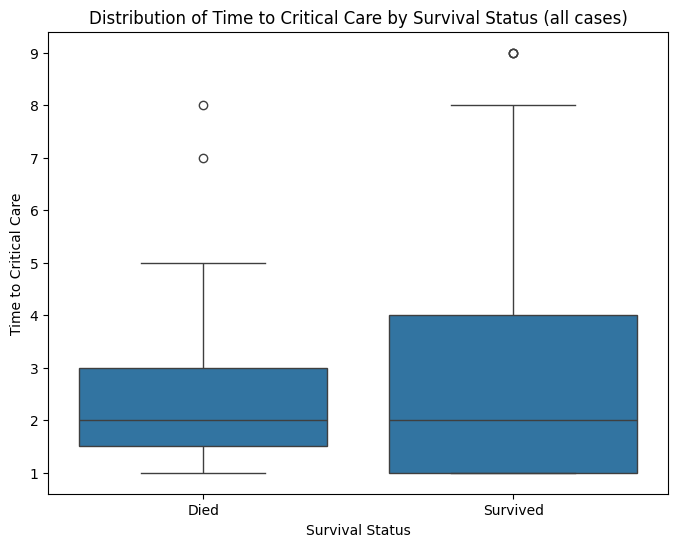

Mann-Whitney U test results:
Statistic: 585.5
P-value: 0.8584658783627286


In [ ]:
### 7.2- probably omit, numerical conversion of time to care categories ###

# Convert 'time_to_crit_care' to numeric, handling errors
df['time_to_crit_care'] = pd.to_numeric(df['time_to_crit_care'], errors='coerce')

# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='alive', y='time_to_crit_care', data=df)
plt.xticks([0, 1], ['Died', 'Survived'])
plt.xlabel('Survival Status')
plt.ylabel('Time to Critical Care')
plt.title('Distribution of Time to Critical Care by Survival Status (all cases)')
plt.show()

# Mann-Whitney U test
group_0 = df[df['alive'] == 0]['time_to_crit_care'].dropna()
group_1 = df[df['alive'] == 1]['time_to_crit_care'].dropna()
statistic, p_value = mannwhitneyu(group_0, group_1)

print(f"Mann-Whitney U test results:")
print(f"Statistic: {statistic}")
print(f"P-value: {p_value}")

Spearman correlation between Pim3 score and time to critical care: 0.08512423610255679

# Supplementary Figure 7 



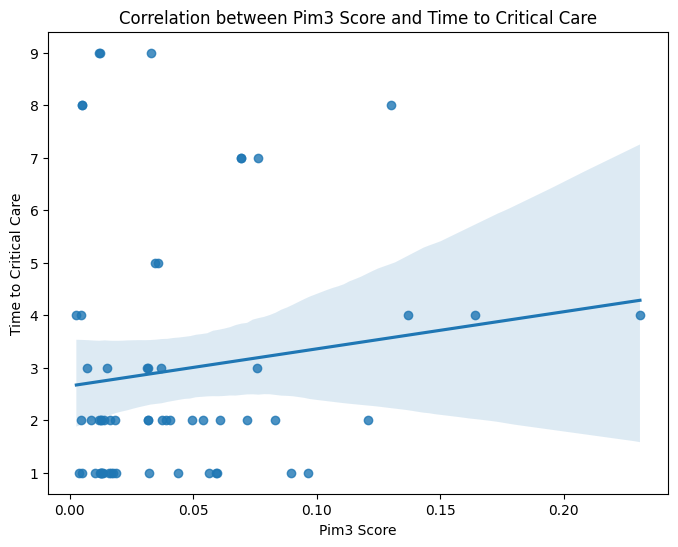

In [ ]:
#### 7.3 - Supplementary Figure 7 - Pim3 score (numerical) / time_to_crit_care (ordinal) correlation
# Calculate the correlation between Pim3 score and time_to_crit_care
correlation = df['pim3'].corr(df['time_to_crit_care'], method='spearman')  # Use Spearman for ordinal data

print(f"Spearman correlation between Pim3 score and time to critical care: {correlation}")

# Visualize the relationship using a scatter plot
plt.figure(figsize=(8, 6))
sns.regplot(x='pim3', y='time_to_crit_care', data=df)
plt.xlabel('Pim3 Score')
plt.ylabel('Time to Critical Care')
plt.title('Correlation between Pim3 Score and Time to Critical Care')
print("\n# Supplementary Figure 7 \n")
plt.show()

In [ ]:
########################
# Section 8 - Previous clinical review
########################

In [ ]:
### 8.1 - Prior care table ###

#First remove no data available entries
filtered_df = df[df['prior_attendance'] != 2]

# Create a cross-tabulation of prior attendance category and alive status
prior_care_crosstab = pd.crosstab(filtered_df['prior_attendance'], df['alive'])

# Calculate the total number of patients in each prior attedance category
prior_totals = prior_care_crosstab.sum(axis=0)

# Calculate the percentage of patients in each alive category
prior_percentages = prior_care_crosstab.div(prior_totals, axis=1) * 100

# Concatenate the counts and percentages into a single DataFrame
# Set 'prior_attendance' as index to keep it as a column
prior_summary_table = pd.concat([prior_care_crosstab, prior_percentages], axis=1, keys=['Count', '% of Total'])
prior_summary_table = prior_summary_table.rename_axis('prior_attendance') # Added to preserve column
prior_summary_table = prior_summary_table.reset_index() #Added to preserve column

#Rename categories
prior_summary_table['prior_attendance'] = prior_summary_table['prior_attendance'].replace({
    0: 'No',
    1: 'Secondary care',
    2: 'No data available',
    3: 'Primary care'
})

# Display the table
display(prior_summary_table)

prior_attendance Count     % of Total          
alive                    0.0 1.0        0.0       1.0
0                   No    11  44       55.0  86.27451
1       Secondary care     6   7       30.0  13.72549
2         Primary care     3   0       15.0   0.00000

In [ ]:
###8.2- Prior care stats - removed as not recorded for alive patients ###

alive             0.0  1.0
prior_attendance          
No                 11   44
Yes                 9    7
Chi-squared statistic: 6.357430648395721
P-value: 0.011689069338273175
Degrees of freedom: 1
Expected frequencies: [[15.49295775 39.50704225]
 [ 4.50704225 11.49295775]]


In [ ]:
########################
# Extra bits and pieces probably omit
########################

In [ ]:
### Extra 1 - Pim3 score (numerical) / ethnicity (ordinal) correlation ###
# Calculate the correlation between Pim3 score and time_to_crit_care
correlation = df['pim3'].corr(df['ethnicity'], method='spearman')  # Use Spearman for ordinal data

print(f"Spearman correlation between Pim3 score and ethnicity: {correlation}")

# Visualize the relationship using a scatter plot
plt.figure(figsize=(8, 6))
sns.regplot(x='ethnicity', y='pim3', data=df)
plt.xlabel('Ethnicity')
plt.ylabel('Pim3')
plt.title('Correlation between Pim3 Score and Ethnicity')
plt.show()

Spearman correlation between Pim3 score and ethnicity: 0.04001656559259377


In [ ]:
#### Extra 2 - Pim3 score (numerical) / SIMD decile (ordinal) correlation ###
correlation = df['pim3'].corr(df['SIMD 2020v2_sc_decile'], method='spearman')  # Use Spearman for ordinal data

print(f"Spearman correlation between Pim3 score and SIMD decile: {correlation}")

# Visualize the relationship using a scatter plot
plt.figure(figsize=(8, 6))
sns.regplot(x='SIMD 2020v2_sc_decile', y='pim3', data=df)
plt.xlabel('SIMD decile')
plt.ylabel('Pim3')
plt.title('Correlation between Pim3 Score and SIMD score')
plt.show()

Spearman correlation between Pim3 score and SIMD decile: -0.21521327413807675


In [ ]:
### Extra 3 - Admission summary stats ###

hosp_length_stats = df['hosp_length'].describe()
picu_length_stats = df['picu_length'].describe()
ventilated_hours_stats = df['ventilated_hours'].describe()
inotropic_hours_stats = df['inotropic_hours'].describe()

# Concatenate and transpose
combined_stats = pd.concat([hosp_length_stats, picu_length_stats, ventilated_hours_stats, inotropic_hours_stats], axis=1)
combined_stats = combined_stats.T  # Transpose to have statistics as rows

# Display the table
print(combined_stats)

                  count        mean         std  min   25%   50%     75%  \
hosp_length        63.0   23.412698   21.574055  8.0  12.5  17.0   26.00   
picu_length        63.0    8.031746    7.536938  0.0   3.0   7.0   10.50   
ventilated_hours   63.0  120.736508  123.913340  2.0  34.5  78.5  174.25   
inotropic_hours    63.0   44.515873   55.687779  0.0   0.0  34.0   59.00   

                    max  
hosp_length       164.0  
picu_length        40.0  
ventilated_hours  663.5  
inotropic_hours   284.0  


In [ ]:
########################
# Meta data for notebook
########################

In [ ]:
# Get the total number of code cells
num_code_cells = len([cell for cell in get_ipython().user_ns['In'] if cell is not None])

# Get the total number of lines of code in the notebook
lines_of_code = 0
# Iterate using the range of keys instead of the keys themselves.
for cell_key in range(len(get_ipython().user_ns['In'])):
    #Check if the cell exists
    if get_ipython().user_ns['In'][cell_key] is not None:
        cell_content = get_ipython().user_ns['In'][cell_key]
        lines_of_code += len(cell_content.splitlines())

# Display the results
print(f"Total code cells: {num_code_cells}")
print(f"Total lines of code: {lines_of_code}")

Total code cells: 108
Total lines of code: 4052
